# Clasificación de Ingresos con Machine Learning para Análisis Socioeconómico

## Introducción

En este proyecto se desarrolla un sistema de **clasificación de ingresos personales** basado en modelos de *machine learning*, cuyo objetivo es predecir si un individuo gana **más o menos de \$50K anuales** utilizando datos demográficos y laborales extraídos del censo.

El sistema está diseñado para analizar registros individuales y, mediante un algoritmo de **clasificación supervisada**, identificar patrones socioeconómicos relevantes que puedan ser útiles en estudios de mercado, políticas públicas, o decisiones comerciales.

Adicionalmente, se contempla la posibilidad de extender el análisis para generar **visualizaciones interactivas** o aplicar técnicas de segmentación poblacional con fines estadísticos o estratégicos.

### Objetivo

- Desarrollar un modelo capaz de **predecir el nivel de ingresos** de una persona a partir de datos censales.
- Aplicar técnicas de *preprocesamiento*, *entrenamiento* y *evaluación* de modelos de clasificación binaria.
- Diseñar un pipeline reproducible que permita aplicar el modelo en nuevos conjuntos de datos.

### Alcance del Proyecto

- Exploración de datos (EDA) y visualización de variables clave.
- Entrenamiento y validación de modelos de clasificación (por ejemplo: Regresión Logística, Árboles de Decisión, Random Forest).
- Evaluación de métricas como *accuracy*, *precision*, *recall*, y *f1-score*.
- Identificación de las variables más relevantes mediante técnicas de importancia de características.
- Optimización de modelos.

### Uso Comercial

Este tipo de análisis tiene múltiples aplicaciones prácticas en sectores como:

- **Banca y Finanzas**: Evaluación crediticia y segmentación de clientes.
- **Marketing**: Diseño de campañas según el perfil socioeconómico.
- **Gobierno y ONGs**: Políticas de inclusión y estudios poblacionales.

### Dataset Utilizado: Adult Census Income

Se utiliza el *dataset* **Adult Census Income (también conocido como Census Income)**, extraído del Censo de EE. UU. de 1994 y preparado por Ronny Kohavi y Barry Becker para tareas de minería de datos.

Características principales del *dataset*:

- **Número de instancias**: 32561 registros.
- **Atributos**: 14 variables incluyendo edad, educación, ocupación, horas trabajadas por semana, entre otros.
- **Variable objetivo**: `income`, que indica si el individuo gana `>50K` o `<=50K` al año.
- **Tipo de datos**: Mixto (categóricos y numéricos).
- **Fuente original**: Base de datos de la Oficina del Censo de los Estados Unidos.


> **Nota sobre la limpieza del dataset**:
> 
> Antes de incluir los registros en el conjunto de datos final, se aplicaron ciertos **filtros de limpieza** para asegurar que los datos sean relevantes y de calidad. Estos filtros fueron:
>
> - `AAGE > 16`: Se excluyen personas menores de 17 años, ya que generalmente no participan activamente en el mercado laboral.
> - `AGI > 100`: Aunque `AGI` no figura directamente en la versión final, este filtro garantiza que se consideren solo registros con ingresos válidos y no triviales.
> - `AFNLWGT > 1`: Se descartan registros con peso muestral casi nulo. El campo `fnlwgt` indica cuántas personas en la población representa ese registro. Si es muy bajo, el dato tiene poca relevancia estadística.
> - `HRSWK > 0`: Se omiten personas que no trabajan nada en la semana, ya que no aportan información útil al análisis de ingresos.
>
> Estos filtros ayudan a mantener un conjunto de datos limpio, útil y representativo para entrenar modelos de clasificación.


#### Acceso al Dataset

El *dataset* puede descargarse desde Kaggle:

👉 [Adult Census Income Dataset en Kaggle](https://www.kaggle.com/datasets/uciml/adult-census-income)

Esta versión puede contener columnas mejor etiquetadas y separadas para análisis más avanzados o uso con frameworks como **TensorFlow**, **PyTorch** o **XGBoost**.

#### Basado en investigaciones académicas

Este proyecto toma como base el trabajo académico publicado por:

> **Ron Kohavi**, “Scaling Up the Accuracy of Naive-Bayes Classifiers: a Decision-Tree Hybrid”, *KDD 1996*.

Además, es ampliamente utilizado como benchmark en cursos, certificaciones y desafíos de ciencia de datos debido a su simplicidad y valor práctico.

Para este trabajo se utilizará la versión en Kaggle, por su formato limpio y accesible.

### Librerías a utilizar

A continuación se listan todas las librerías usadas en este notebook.

In [1]:
# Manipulación de datos
import pandas as pd
import numpy as np
import kagglehub
import os
from scipy.stats import randint, uniform

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Modelos de clasificación
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Evaluación
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score,
    f1_score, 
    classification_report, 
    confusion_matrix,
    precision_recall_curve
)

# Guardar y cargar modelos
import joblib

## EDA: Exploratory Data Analysis

El primer paso en este proyecto es realizar un análisis exploratorio de datos (EDA) sobre el *dataset* **Adult Census Income**. Este proceso es clave para entender la naturaleza de los datos disponibles y preparar el terreno para la fase de modelado.

A diferencia de otros *datasets* integrados en librerías como `scikit-learn`, el *Adult Income* proviene de fuentes externas (como Kaggle o UCI), y se presenta habitualmente en formato **CSV**. Por lo tanto, podemos utilizar directamente funciones como `head()`, `info()` y `describe()` de **pandas** para comenzar la exploración.

> **Nota**: Antes de aplicar modelos de machine learning, es esencial entender la distribución de los datos, la presencia de valores nulos, y las relaciones entre las variables.

### Descripción del Dataset

El *dataset* Adult Income contiene información demográfica y laboral de individuos adultos residentes en EE.UU., recolectada por la Oficina del Censo. El objetivo es predecir si el ingreso anual de una persona supera los **\$50,000**.

Una vez cargado en un `DataFrame` de `pandas`, el conjunto de datos se verá de la siguiente manera:

| Columna             | Tipo       | Descripción                                                             |
|---------------------|------------|-------------------------------------------------------------------------|
| `age`               | Numérica   | Edad del individuo.                                                    |
| `workclass`         | Categórica | Tipo de empleo (privado, gobierno, autónomo, etc.).                    |
| `fnlwgt`            | Numérica   | Peso muestral (indica cuántas personas representa esta muestra).       |
| `education`         | Categórica | Nivel educativo (HS-grad, Bachelors, etc.).                            |
| `education-num`     | Numérica   | Nivel educativo en formato numérico.                                   |
| `marital-status`    | Categórica | Estado civil.                                                           |
| `occupation`        | Categórica | Ocupación laboral.                                                     |
| `relationship`      | Categórica | Relación familiar (esposo/a, hijo/a, etc.).                            |
| `race`              | Categórica | Raza declarada.                                                        |
| `sex`               | Categórica | Género (Male/Female).                                                  |
| `capital-gain`      | Numérica   | Ganancias de capital obtenidas.                                        |
| `capital-loss`      | Numérica   | Pérdidas de capital registradas.                                       |
| `hours-per-week`    | Numérica   | Cantidad de horas trabajadas por semana.                               |
| `native-country`    | Categórica | País de origen.                                                        |
| `income`            | Categórica | Variable objetivo: `>50K` o `<=50K` (clase a predecir).                |

> **Nota**: Algunas columnas como `education` y `education-num` son redundantes, pero pueden utilizarse para contrastar codificaciones.

### Carga de Datos

Los datos serán descargados directamente desde Kaggle mediante el siguiente código:

In [2]:
# Se descarga la última versión disponible del dataset "adult-census-income" desde el repositorio "uciml" en Kaggle.
path = kagglehub.dataset_download("uciml/adult-census-income")  

# Se imprime la ruta local en la que se han almacenado los archivos descargados del dataset.
print("Path to dataset files:", path)

# Mostrar todos los archivos descargados en el path del dataset
print("\nArchivos en el path:")
for file in os.listdir(path):
    print(file)

Path to dataset files: C:\Users\George\.cache\kagglehub\datasets\uciml\adult-census-income\versions\3

Archivos en el path:
adult.csv


El siguiente paso será crear una función utilizando las librerías os y pandas con el fin de cargar los datos del dataset en formato CSV.

In [3]:
# Se crea una función para guardar los datos del dataset en un objeto
# de tipo dataframe
def load_data(path, name):
    csv_path = os.path.join(path, name)
    return pd.read_csv(csv_path)

Con la función `load_data` se cargan los datos desde el dataset y se crea un objeto de tipo `dataframe` que será llamado `census`. Posteriormente se imprimiran las primeras lineas junto con los atributos del dataset utilizando el método ``head()``, esto permitirá verificar la estructura de los datos con los se va a trabajar.

In [4]:
# Se carga el modelo y es guardado como un objeto dataframe
census = load_data(path,"adult.csv")

# Se muestran las primeras 5 lineas de dicho objeto
census.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


A simple vista se puede obervar que el dataset posee datos numérico y categóricos, tal como se describió al inicio de este documento. Además posee valores faltantes en varias de sus intancias.

### Análisis Inicial

Dentro de las opciones que ofrece la librería ``pandas``, se encuentra la posibilidad de obtener información sobre el objeto de tipo ``dataframe``, que acaba de ser creado, a través del método ``info()``.

In [5]:
# Se muestra la información del objeto
census.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


El método ``info()`` permite determinar que el dataset posee 32,561 entradas y 15 atributos. De estos atributos, 6 son de tipo ``int64`` (enteros) y 9 son de tipo ``object`` (categóricos o texto). Si bien ``info()`` establece que no hay datos nulos, hemos visto celdas que poseen el valor *?* lo que implica que falta información en dicho atributo para esa instancia en particular.

El siguiente paso será usar el método ``describe()`` para obtener información estadística de cada atributo numérico. Aquellos de tipo ``object`` no son tenidos en cuenta.

In [6]:
# El siguiente paso es mostrar la descripción de estadística de
# los atributos numéricos
census.describe()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


Habiendo determinado las métricas básicas del dataset, analicemos la distribución de cada variable numérica

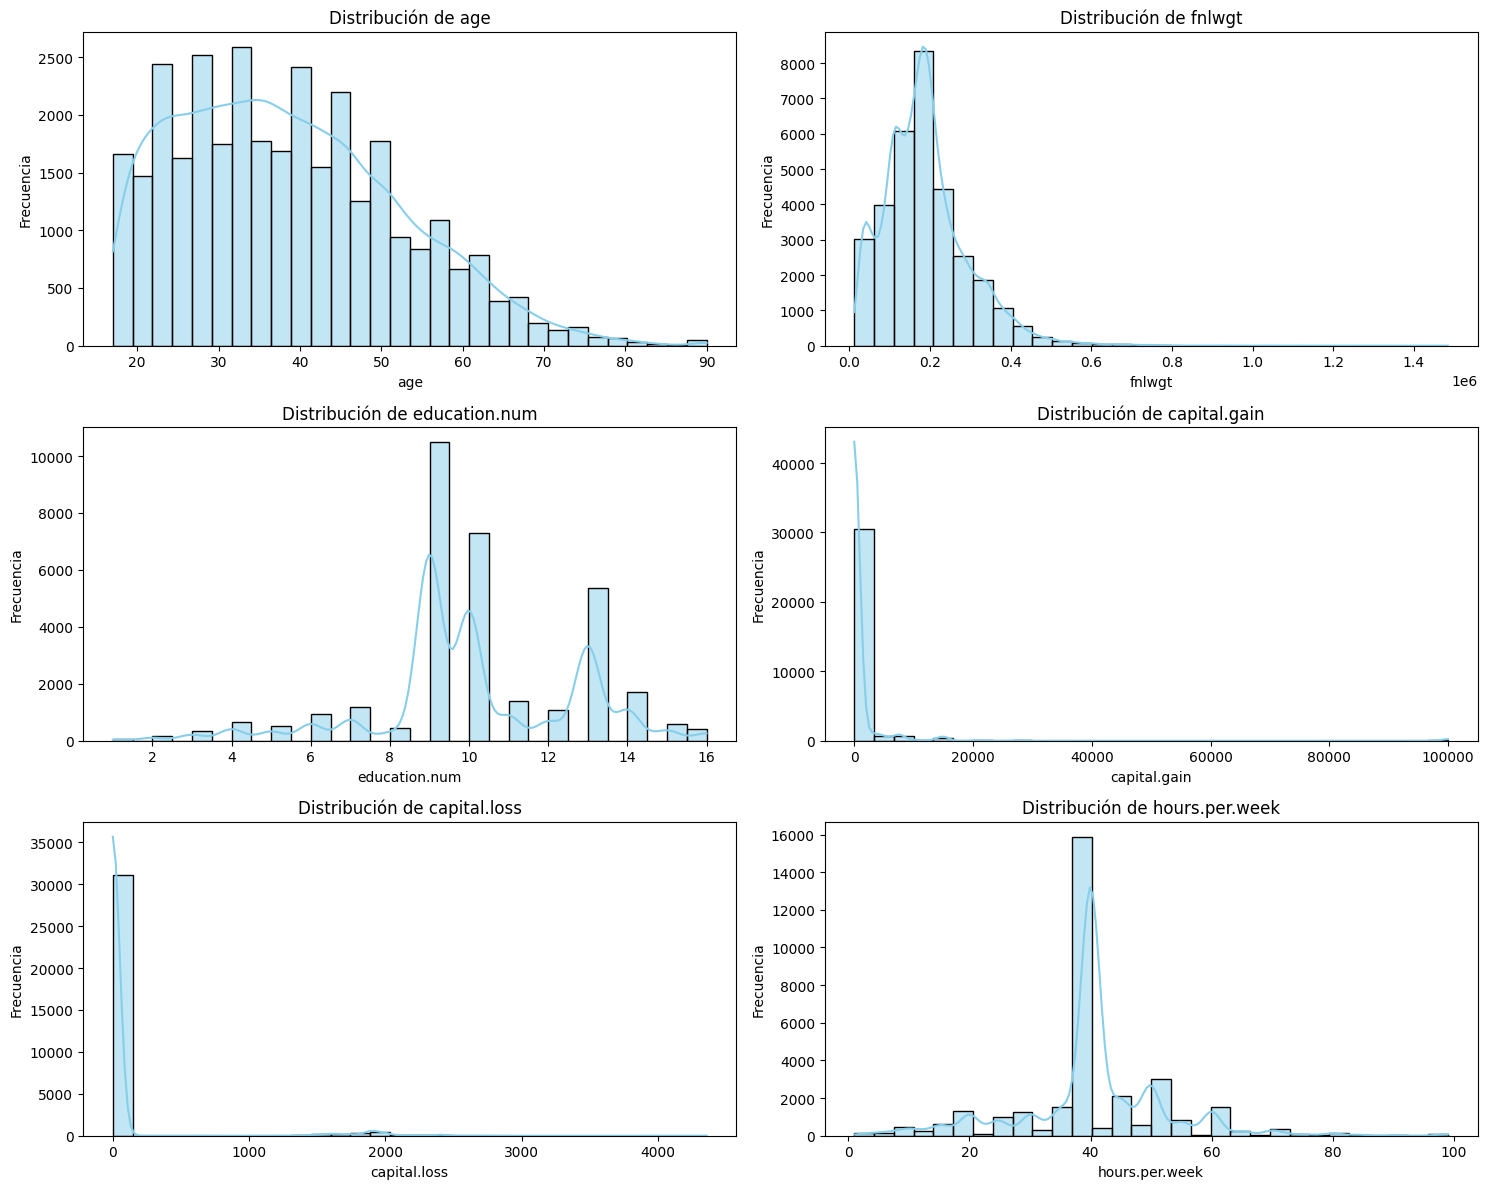

In [7]:
# Definir las variables numéricas del dataset
variables_numericas = ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']

# Definir el tamaño de la figura
plt.figure(figsize=(15, 12))

# Crear un histograma para cada variable numérica
for i, var in enumerate(variables_numericas, 1):
    plt.subplot(3, 2, i)
    sns.histplot(data=census, x=var, kde=True, bins=30, color='skyblue')
    plt.title(f'Distribución de {var}')
    plt.xlabel(var)
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()




El atributo ``age`` representa la edad de los individuos registrados en el dataset. Se observa que la edad mínima es de 17 años y la máxima de 90, con una media de aproximadamente 38.6 años y una desviación estándar de 13.64. Esto indica que el rango de edades es amplio y está moderadamente disperso, siendo la mediana de 37 años. La distribución muestra que al menos el 75% de los individuos tienen una edad inferior a 48 años, lo cual sugiere que se trata principalmente de una población adulta en edad productiva.

El campo ``fnlwgt``, correspondiente al peso final de la muestra, presenta una gran variabilidad, con valores que van desde 12,285 hasta 1,484,705. La media se encuentra alrededor de 189,778 y la desviación estándar es superior a 100,000, lo que indica la presencia de valores altamente dispersos. Dado que este atributo fue diseñado originalmente para ajustar la representatividad de la muestra en estudios censales, su escala no tiene una interpretación directa y puede influir de forma desproporcionada en algunos modelos si no se transforma o normaliza adecuadamente.

Respecto al atributo ``education.num``, que representa un nivel educativo codificado numéricamente, se tiene una media de 10 y un máximo de 16. La mediana también es 10, lo cual indica que la mayoría de los individuos alcanzan un nivel educativo correspondiente a Some-college, es decir, algo de educación universitaria sin necesariamente haberla completado. La desviación estándar de 2.57 sugiere que los niveles educativos tienden a concentrarse en torno a ese valor promedio. Los percentiles muestran que el 75% de los individuos tienen un valor menor o igual a 12, lo cual se asocia con niveles educativos que van desde HS-grad (graduado de secundaria) hasta Assoc-acdm (título asociado académico), es decir, una educación secundaria o terciaria técnica completa.

El atributo ``capital.gain`` presenta una media de 1,077 y una desviación estándar elevada, cercana a los 7,385. No obstante, tanto la mediana como los percentiles 25 y 75 son cero, lo que implica que la gran mayoría de las personas no reportan ganancias de capital. La existencia de un valor máximo de 99,999 indica que hay una pequeña proporción de casos con ganancias atípicamente altas, lo que introduce una fuerte asimetría positiva en la distribución.

De forma similar, ``capital.loss`` tiene un comportamiento marcadamente sesgado. Con una media de 87.3 y una desviación estándar de más de 400, la mayoría de los registros tienen valores nulos en este campo, como lo evidencian sus percentiles más bajos. El valor máximo registrado es de 4,356, lo que también sugiere la presencia de unos pocos casos extremos que podrían afectar negativamente a modelos sensibles a valores atípicos.

Finalmente, el campo ``hours.per.week``, que indica el número de horas trabajadas por semana, tiene una media de 40.4 horas y una mediana de 40, lo cual muestra una tendencia clara hacia jornadas laborales estándar. Sin embargo, el rango va desde 1 hasta 99 horas por semana, lo cual introduce cierta dispersión en los datos. La desviación estándar de 12.3 refuerza esta idea, aunque los percentiles indican que el 75% de los individuos trabajan 45 horas o menos, lo que sugiere una distribución relativamente concentrada alrededor de la media.

El siguiente paso será determinar las categorías dentro de cada uno de los atributos categóricos.

In [8]:
print("Las categorías dentro del atributo workclass son:\n", census["workclass"].value_counts())

Las categorías dentro del atributo workclass son:
 workclass
Private             22696
Self-emp-not-inc     2541
Local-gov            2093
?                    1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: count, dtype: int64


> **Nota**: Este atributo posee 1836 datos faltantes marcados como **?**.

In [9]:
print("Las categorías dentro del atributo education son:\n", census["education"].value_counts())

Las categorías dentro del atributo education son:
 education
HS-grad         10501
Some-college     7291
Bachelors        5355
Masters          1723
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           646
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           333
1st-4th           168
Preschool          51
Name: count, dtype: int64


In [10]:
# Se eliminan duplicados para mostrar cada par único de (education, education.num)
educacion_niveles = census[['education', 'education.num']].drop_duplicates().sort_values(by='education.num')

# Se imprime la relación entre número y nivel educativo
print("La relación entre cada categoría y su valor numérico es la siguiente:")
for _, fila in educacion_niveles.iterrows():
    print(f"{fila['education.num']:>2} → {fila['education']}")

La relación entre cada categoría y su valor numérico es la siguiente:
 1 → Preschool
 2 → 1st-4th
 3 → 5th-6th
 4 → 7th-8th
 5 → 9th
 6 → 10th
 7 → 11th
 8 → 12th
 9 → HS-grad
10 → Some-college
11 → Assoc-voc
12 → Assoc-acdm
13 → Bachelors
14 → Masters
15 → Prof-school
16 → Doctorate


In [11]:
print("Las categorías dentro del atributo marital.status son:\n", census["marital.status"].value_counts())

Las categorías dentro del atributo marital.status son:
 marital.status
Married-civ-spouse       14976
Never-married            10683
Divorced                  4443
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: count, dtype: int64


In [12]:
print("Las categorías dentro del atributo occupation son:\n", census["occupation"].value_counts())

Las categorías dentro del atributo occupation son:
 occupation
Prof-specialty       4140
Craft-repair         4099
Exec-managerial      4066
Adm-clerical         3770
Sales                3650
Other-service        3295
Machine-op-inspct    2002
?                    1843
Transport-moving     1597
Handlers-cleaners    1370
Farming-fishing       994
Tech-support          928
Protective-serv       649
Priv-house-serv       149
Armed-Forces            9
Name: count, dtype: int64


> **Nota**: Este atributo posee 1836 datos faltantes marcados como **?**.

In [13]:
print("Las categorías dentro del atributo relationchip son:\n", census["relationship"].value_counts())

Las categorías dentro del atributo relationchip son:
 relationship
Husband           13193
Not-in-family      8305
Own-child          5068
Unmarried          3446
Wife               1568
Other-relative      981
Name: count, dtype: int64


In [14]:
print("Las categorías dentro del atributo race son:\n", census["race"].value_counts())

Las categorías dentro del atributo race son:
 race
White                 27816
Black                  3124
Asian-Pac-Islander     1039
Amer-Indian-Eskimo      311
Other                   271
Name: count, dtype: int64


In [15]:
print("Las categorías dentro del atributo sex son:\n", census["sex"].value_counts())

Las categorías dentro del atributo sex son:
 sex
Male      21790
Female    10771
Name: count, dtype: int64


In [16]:
print("Las categorías dentro del atributo native.country son:\n", census["native.country"].value_counts())

Las categorías dentro del atributo native.country son:
 native.country
United-States                 29170
Mexico                          643
?                               583
Philippines                     198
Germany                         137
Canada                          121
Puerto-Rico                     114
El-Salvador                     106
India                           100
Cuba                             95
England                          90
Jamaica                          81
South                            80
China                            75
Italy                            73
Dominican-Republic               70
Vietnam                          67
Guatemala                        64
Japan                            62
Poland                           60
Columbia                         59
Taiwan                           51
Haiti                            44
Iran                             43
Portugal                         37
Nicaragua                    

In [17]:
print("Las categorías dentro del atributo income son:\n", census["income"].value_counts())

Las categorías dentro del atributo income son:
 income
<=50K    24720
>50K      7841
Name: count, dtype: int64


Ahora veamos esta misma información de manera gráfica.

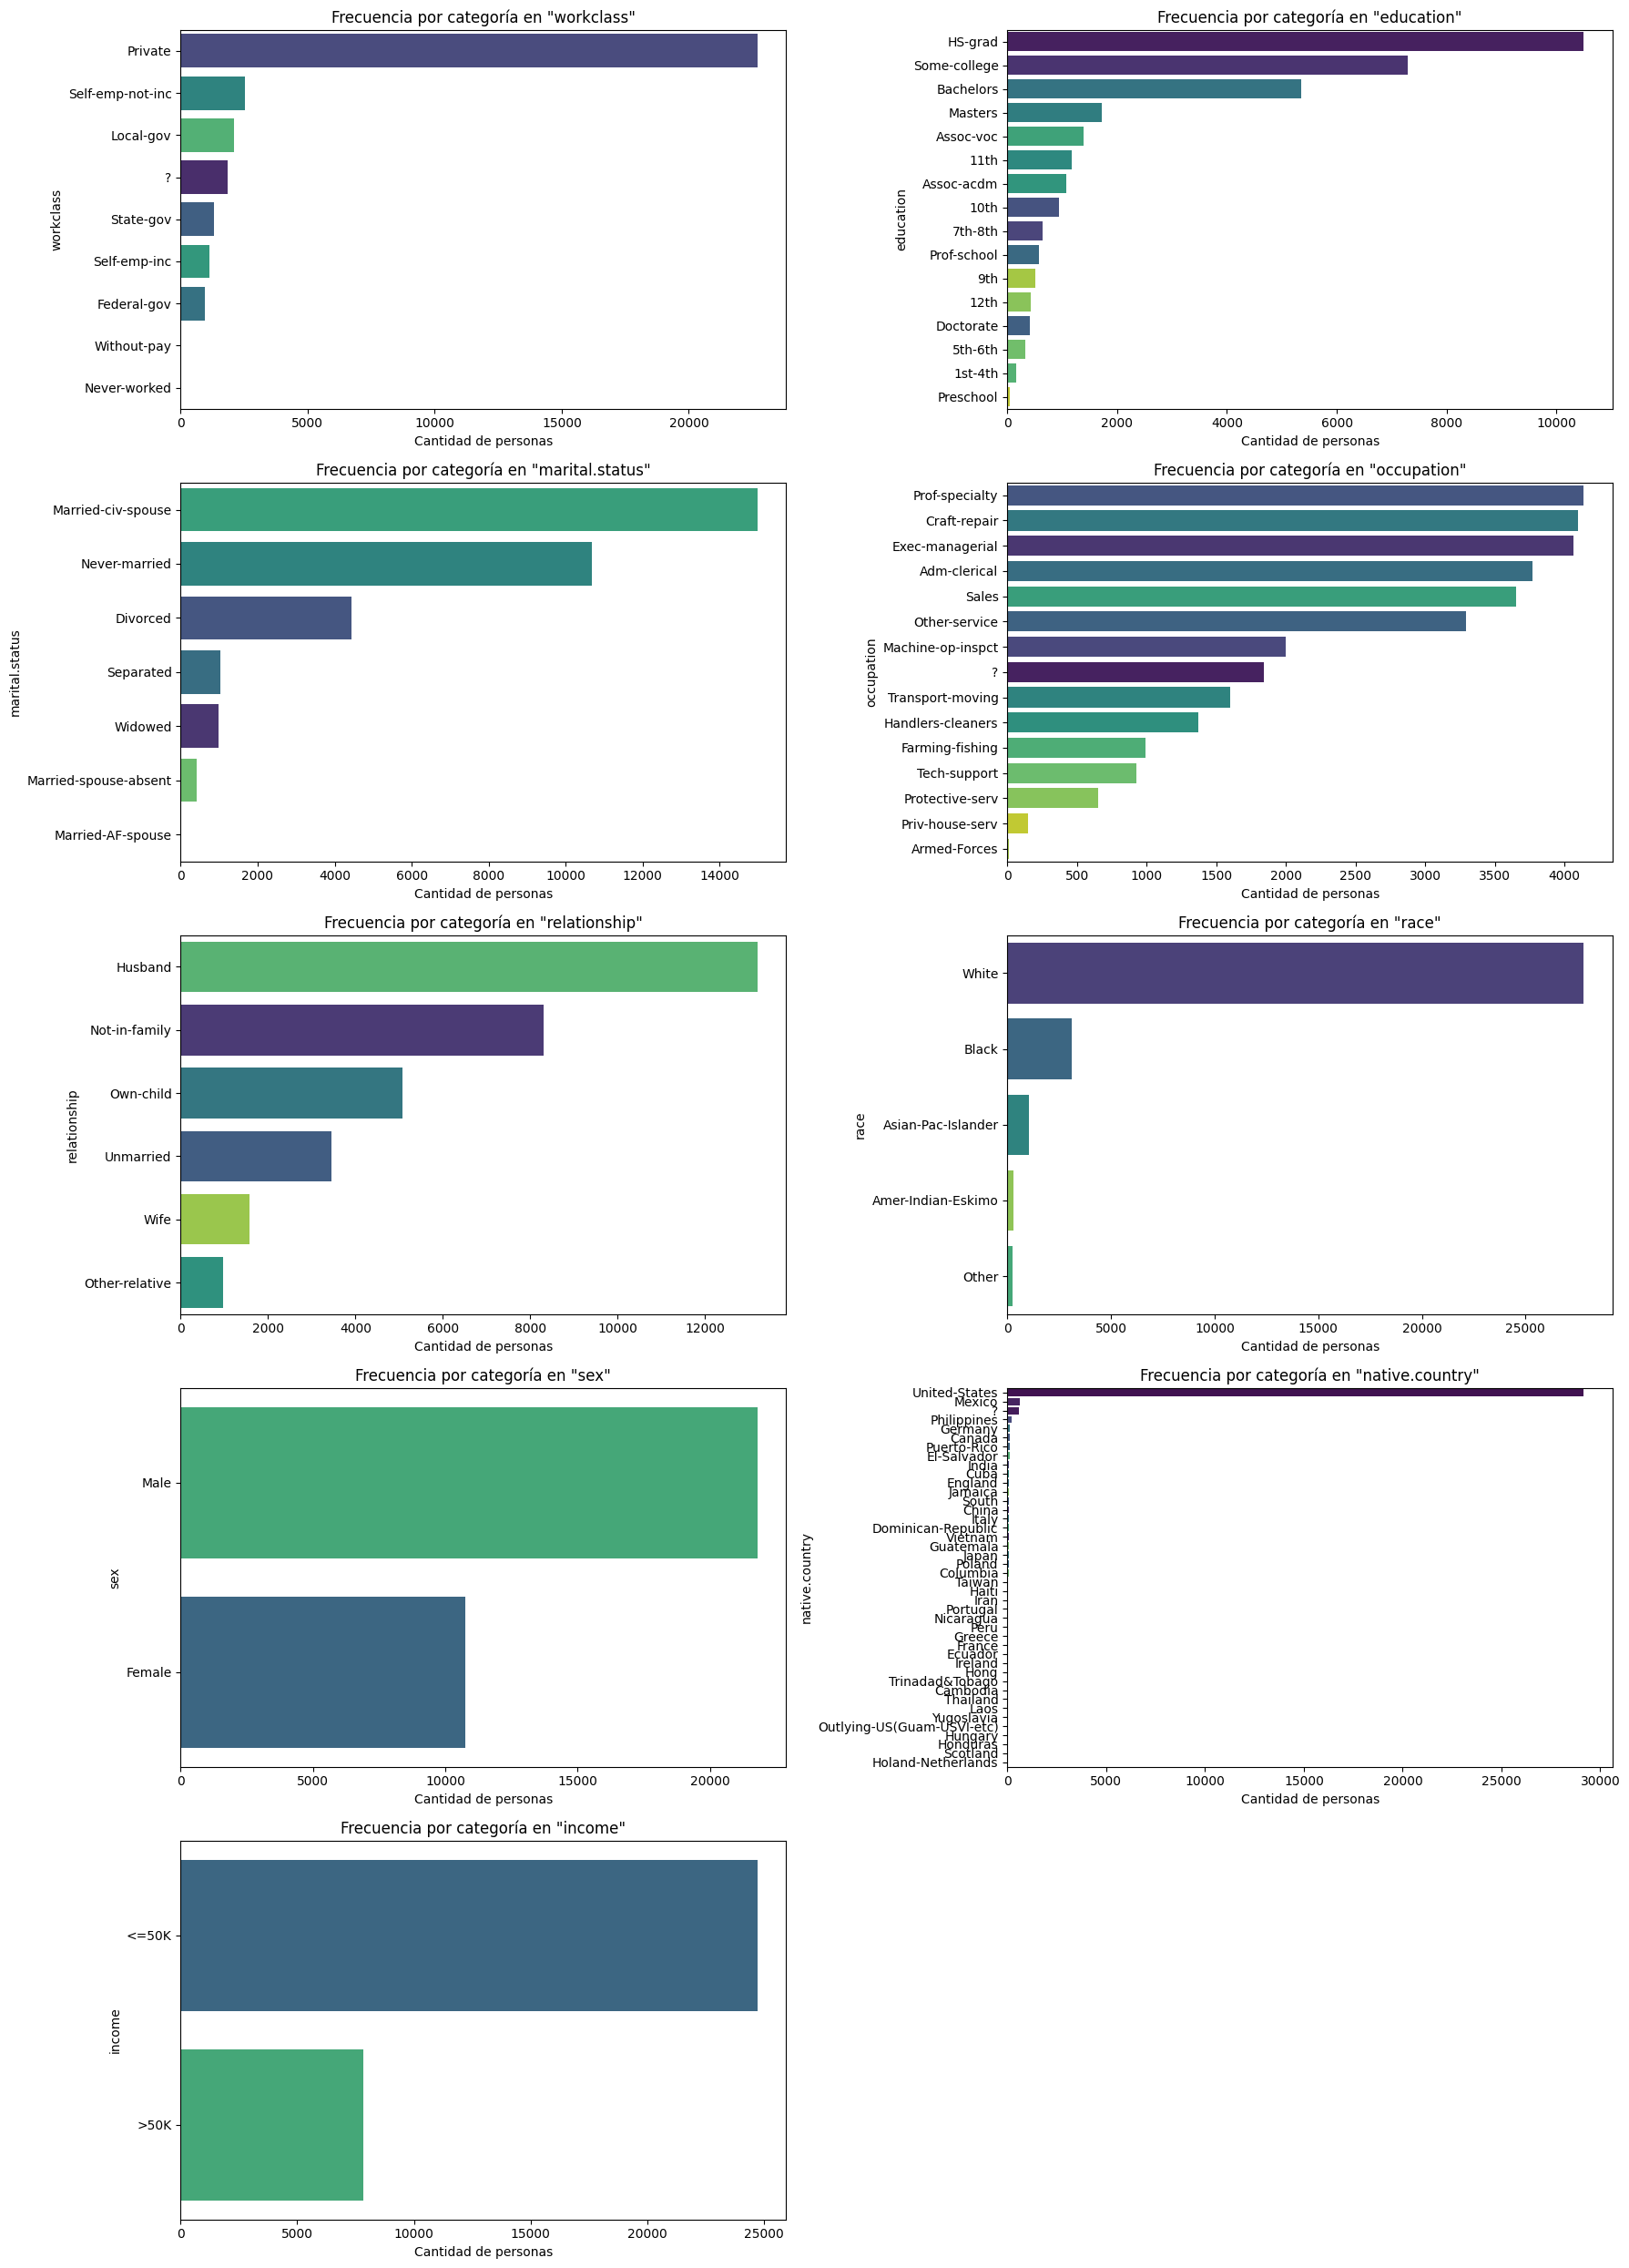

In [18]:
# Definir las variables categóricas del dataset
variables_categoricas = ['workclass', 'education', 'marital.status', 
                         'occupation', 'relationship', 'race', 
                         'sex', 'native.country', 'income']

# Definir el tamaño de la figura
plt.figure(figsize=(18, 25))

# Crear un gráfico de barras para cada variable categórica
for i, var in enumerate(variables_categoricas, 1):
    plt.subplot(5, 2, i)
    sns.countplot(data=census, y=var, hue=var, legend=False,
                  order=census[var].value_counts().index,
                  palette='viridis')
    plt.title(f'Frecuencia por categoría en "{var}"')
    plt.xlabel('Cantidad de personas')
    plt.ylabel(var)

plt.tight_layout()
plt.show()

### Ingeniería de Atributos

#### Análisis de Valores Faltantes

Los datos faltantes se encuentran en 3 atributos específicamente: ``workclass``, ``occupation`` y ``native.country``. Es necesario primero determinar si las personas con ``workclass`` y ``occupation`` igua a ? son las mismas.

In [19]:
# Crear filtros
filtro_workclass = census['workclass'] == '?'
filtro_occupation = census['occupation'] == '?'

# También contar cuántas filas cumplen ambas condiciones simultáneamente
coinciden_ambos = (filtro_workclass & filtro_occupation).sum()
solo_workclass = (filtro_workclass & ~filtro_occupation).sum()
solo_occupation = (filtro_occupation & ~filtro_workclass).sum()

print("Instancias donde ambos son '?':", coinciden_ambos)
print("Solo workclass es '?':", solo_workclass)
print("Solo occupation es '?':", solo_occupation)


Instancias donde ambos son '?': 1836
Solo workclass es '?': 0
Solo occupation es '?': 7


La diferencia solo son 7 personas, por lo que determinarán el ``workclass`` de estas 7 que difieren.

In [20]:
# Filtrar las instancias donde workclass ≠ '?' y occupation == '?'
filtro = (census['workclass'] != '?') & (census['occupation'] == '?')

# Mostrar las filas que cumplen esta condición
print(census[filtro])


       age     workclass  fnlwgt     education  education.num  \
8874    18  Never-worked  206359          10th              6   
13675   23  Never-worked  188535       7th-8th              4   
17089   17  Never-worked  237272          10th              6   
21934   18  Never-worked  157131          11th              7   
24483   20  Never-worked  462294  Some-college             10   
32331   30  Never-worked  176673       HS-grad              9   
32338   18  Never-worked  153663  Some-college             10   

           marital.status occupation   relationship   race     sex  \
8874        Never-married          ?      Own-child  White    Male   
13675            Divorced          ?  Not-in-family  White    Male   
17089       Never-married          ?      Own-child  White    Male   
21934       Never-married          ?      Own-child  White  Female   
24483       Never-married          ?      Own-child  Black    Male   
32331  Married-civ-spouse          ?           Wife  Black 

Podemos observar que estas personas estan categorizadas en su atributo ``workclass`` como ``Never-Worked`` aún cuando poseen horas semanales destinadas a trabajar: 
- Pueden existir muchas causas por la que estas personas no poseen ocupación registrada, como no poseer un trabajo formal o llevar a cabo tareas domésticas o de voluntariado, lo cual justifica la cantidad de horas trabajadas, pero va en contra de su categoría de ``Never-Worked``.
- También puede ser que estas personas estén desempleadas, y nunca hayan trabajado, motivo por el cual poseen la categoría ``Never-Worked`` y por error se haya cargado una cantidad de horas semanales de trabajo.

#### Eliminación de Instancias Inconsistentes

Caulquiera sea el caso, esto representa una inconsistencia en los datos que pueden modificar el desarrollo de un modelo a futuro, por lo que estas instancias no searán consideradas durante el entrenamiento.

Se establece entonces una nueva versión del dataset donde estos datos será eliminados.

In [21]:
# Se crea una copia del dataset original
census_limpio = census.copy()

# Se eliminan las filas donde 'workclass' es igual a 'Never-worked'
census_limpio = census_limpio[census_limpio['workclass'] != 'Never-worked']

# Se imprime la cantidad de filas restantes
print(f"Número de filas después de eliminar 'Never-worked': {census_limpio.shape[0]}")

Número de filas después de eliminar 'Never-worked': 32554


El resto de las personas que poseen ``occupation`` igual a **?**, también poseen ``workclass`` igual a **?**. El siguiente paso será completar dichos valores o determinar si deben ser eliminados del dataset.

#### Hipótesis para Completado de Dataset

Se establece una primer hipótesis: Las personas con ``workclass`` y ``occupation`` igual a **?** puede que sean jubilados. Se debe determinar si hay personas que poseen una edad superior a 62 años, que es la edad jubilatoria mínima en USA.

In [22]:
# Se filtran las filas donde occupation y workclass son '?' simultáneamente
filtro = (census_limpio['occupation'] == '?') & (census_limpio['workclass'] == '?')

# Se aplica el filtro junto con la condición de edad > 62
mayores_62 = census_limpio[filtro & (census_limpio['age'] > 62)]

# Se imprime la cantidad de personas que cumplen ambas condiciones
print(f"Número de personas mayores de 62 años con occupation y workclass igual a '?': {len(mayores_62)}")

Número de personas mayores de 62 años con occupation y workclass igual a '?': 415


Dada la cantidad de personas que se ajustan al perfil, se agregará una nueva categoría en ambos denominada ``retired``.

In [23]:
# Se reemplaza '?' por 'Retired' en occupation para personas mayores de 62 años
census_limpio.loc[filtro & (census_limpio['age'] > 62), 'occupation'] = 'Retired'

# Se reemplaza '?' por 'Retired' en workclass para personas mayores de 62 años
census_limpio.loc[filtro & (census_limpio['age'] > 62), 'workclass'] = 'Retired'

Para establecer nuevas hipótesis que nos permitan entender los datos y completar los valores faltantes se implementará un procesos de **codificación ordinal** mediante el cual se convertirá a las variables categóricas en numéricas. Acto seguido se creará una matríz de correlaciones utilizando el método ``corr()``.

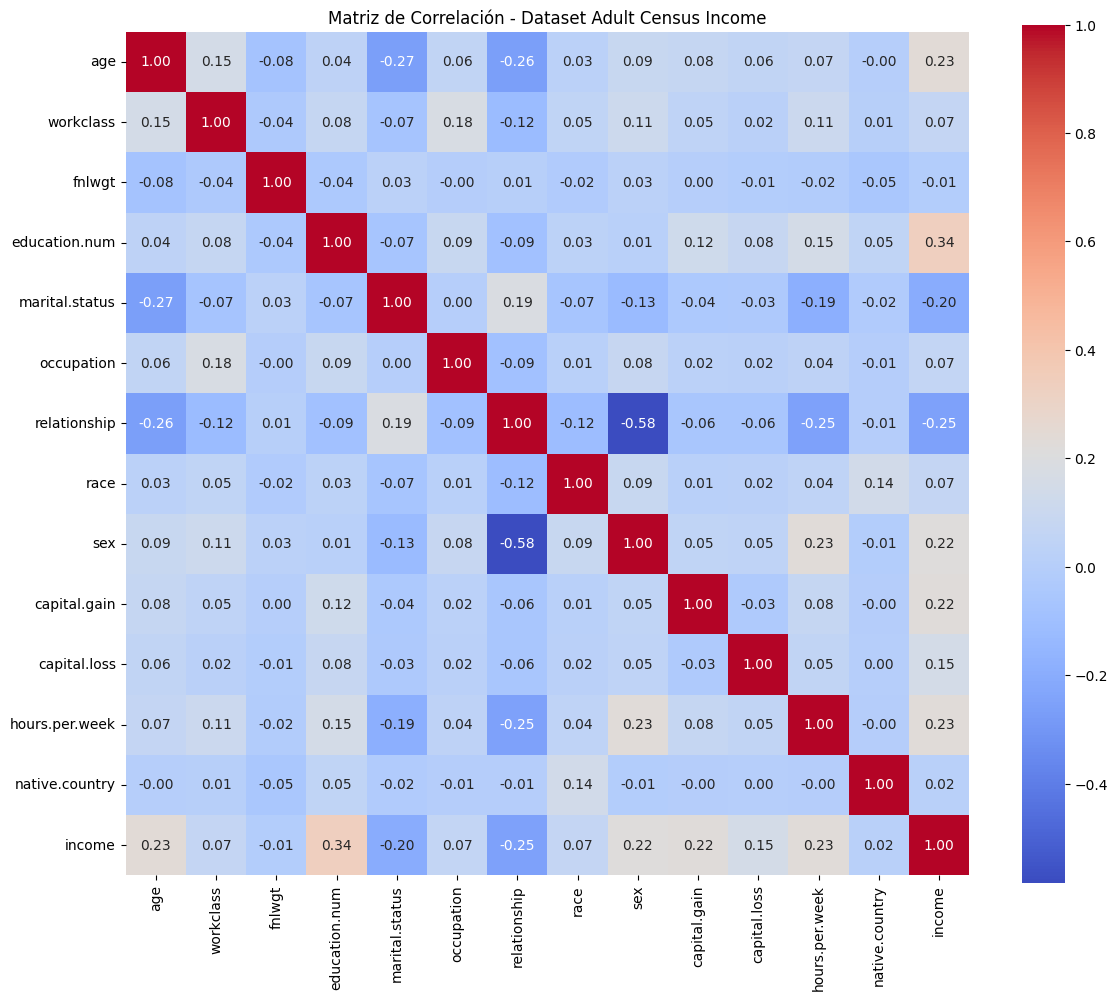

In [24]:
# Crear una copia para trabajar sin modificar el original
census_numerico = census_limpio.copy()

# El atributo education y education.num son lo mismo, por lo que se elimina la versión categórica
census_numerico = census_numerico.drop(columns=["education"])

# Identificar columnas categóricas
categorical_cols = census_numerico.select_dtypes(include=['object']).columns

# Codificar categorías como números
for col in categorical_cols:
    census_numerico[col] = census_numerico[col].astype('category').cat.codes

# Calcular la matriz de correlación
correlation_matrix = census_numerico.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt=".2f", square=True)
plt.title("Matriz de Correlación - Dataset Adult Census Income")
plt.tight_layout()
plt.show()

En base a la matriz de correlaciones se determina que no existe correlación entre la mayoria de los atributos del dataset. El valor negativo máximo es -0.58 entre ``sex`` y ``relationship``. El positivo más alto es sólo de 0.34 entre ``education`` y ``income``. La gran mayoría de las demás correlaciones no superan el 10 u 11%, por lo que no son significativas, mientras hay un segundo grupo menos voluminoso que ronda entre el 20 y el 30%.

Al analizar cada atributo del dataset, algunos resaltan por tener más relaciones con los demás, tales como: ``age``, ``marital.status``, ``sex``, ``hours.per.week`` y ``income``. ``education.num`` interesantemente no posee mucha correlación con los demás excepto por ``income``.

Estudiando más de cerca las categorias, notamos que hay muchas personas en el censo en edad universitaria, con horas de trabajo semanal y sin ocupación. Una hipótesis interesante a considerar es que aquellas personas que estudian, no poseen ocupación, ya que ``student`` no es una categoría actualmente en el dataset. En ese caso, sí trabajarían horas por semana, pero no sería un trabajo pago. Esta posibilidad sugiere que el dataset podría estar omitiendo de forma semántica a estudiantes activos, representándolos con valores faltantes (**?**) en los campos ``occupation`` y ``workclass``. Al observar que algunas de estas personas registran horas trabajadas semanalmente a pesar de no tener ocupación formal, se infiere que podrían estar involucradas en actividades no remuneradas como estudios, prácticas, voluntariados o tareas informales. Para indagar más a fondo, el análisis filtra a individuos con valores **?** en ambos atributos, que trabajen más de cero horas semanales, tengan menos de 30 años y posiblemente un estado civil como ``Never-married``, ya que este perfil es consistente con el de una persona joven en etapa educativa y sin empleo formal, lo que refuerza la validez de la hipótesis. Este subgrupo será almacenado en un nuevo dataframe llamado ``posibles_estudiantes``.

Cantidad de posibles estudiantes: 788


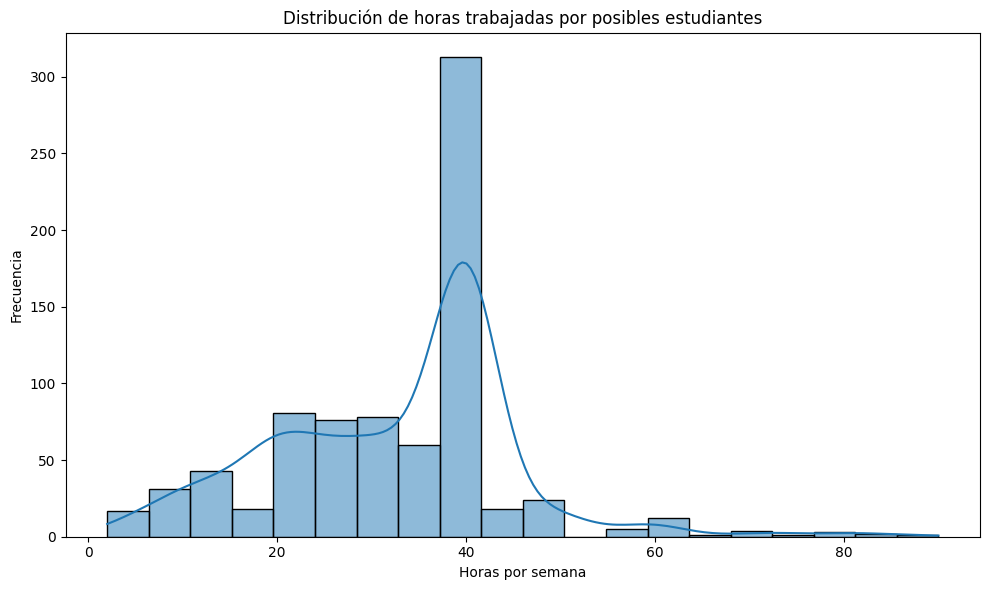

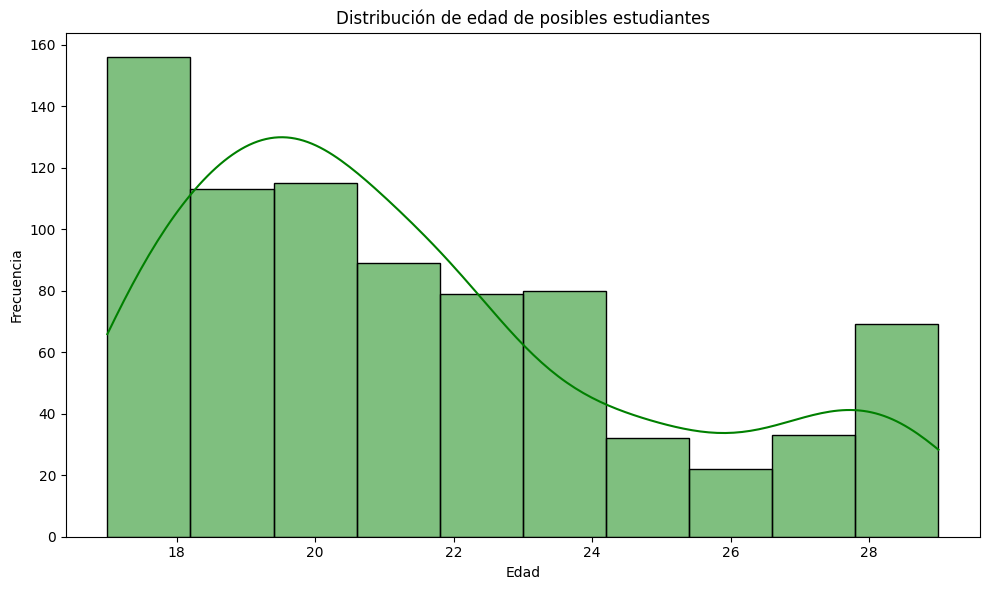

In [25]:
# Filtrar posibles estudiantes: sin ocupación registrada, trabajan horas > 0, edad < 30
posibles_estudiantes = census_limpio[
    (census_limpio['occupation'] == '?') &
    (census_limpio['hours.per.week'] > 0) & # El filtro se agrega igualmente, aunque no hay nadie con 0 horas
    (census_limpio['age'] < 30)
]

# Mostrar cantidad de posibles estudiantes
print(f"Cantidad de posibles estudiantes: {len(posibles_estudiantes)}")

# Distribución de las horas trabajadas por semana
plt.figure(figsize=(10, 6))
sns.histplot(posibles_estudiantes['hours.per.week'], bins=20, kde=True)
plt.title("Distribución de horas trabajadas por posibles estudiantes")
plt.xlabel("Horas por semana")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

# Distribución de edades
plt.figure(figsize=(10, 6))
sns.histplot(posibles_estudiantes['age'], bins=10, kde=True, color='green')
plt.title("Distribución de edad de posibles estudiantes")
plt.xlabel("Edad")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

Si bien los datos del dataframe ``posibles_estudiantes`` muestran que la mayoría de las personas poseen una edad de 26 años o menos, con una ocupación de 20 a 40 horas (siendo este el máximo), esto no es definitivo para determinar si son estudiantes o poseen un trabajo informal.

Para poder determinar con mayor precisión la ocupación de estas personas, se graficará la relación existente entre los atributos ``education`` y ``age``, utilizando ``boxplot``.

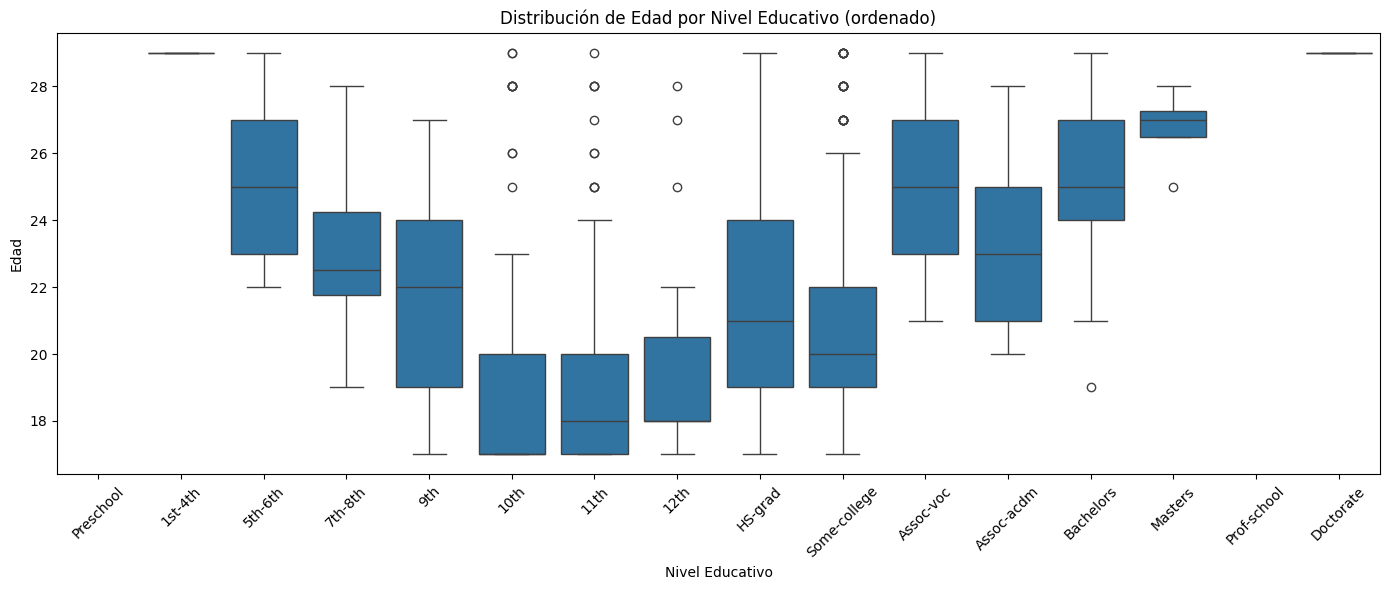

In [26]:
# Ordenar 'education' según 'education.num'
orden_educacion = census_limpio.groupby("education")["education.num"].mean().sort_values().index

# Crear boxplot con orden
plt.figure(figsize=(14, 6))
sns.boxplot(
    data=posibles_estudiantes,
    x="education",
    y="age",
    order=orden_educacion
)
plt.title("Distribución de Edad por Nivel Educativo (ordenado)")
plt.xlabel("Nivel Educativo")
plt.ylabel("Edad")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Este gráfico si proporciona información más interesante, donde se puede ver que las personas dentro del dataframe ``posibles_estudiantes`` poseen un nivel educativo que varía considerablemente. Muchas de ellas posee el secundario sin terminar en un rango de edades bastante amplio. Al poseer ingresos, pero no ocupación, se puede estimar estimar que poseen trabajo no registrado o son desempleados. Aquellos con formación categorizada como ``Some-collage`` y entre las edades de 17 a 22 años pueden representar estudiantes, mientras que los demás puede representar gente desocupada o con trabajo informal dependiendo de la cantidad de horas de ocupación semanal.

A continuación se graficará la relación entre edad y horas trabajadas para entender esta dimensión.

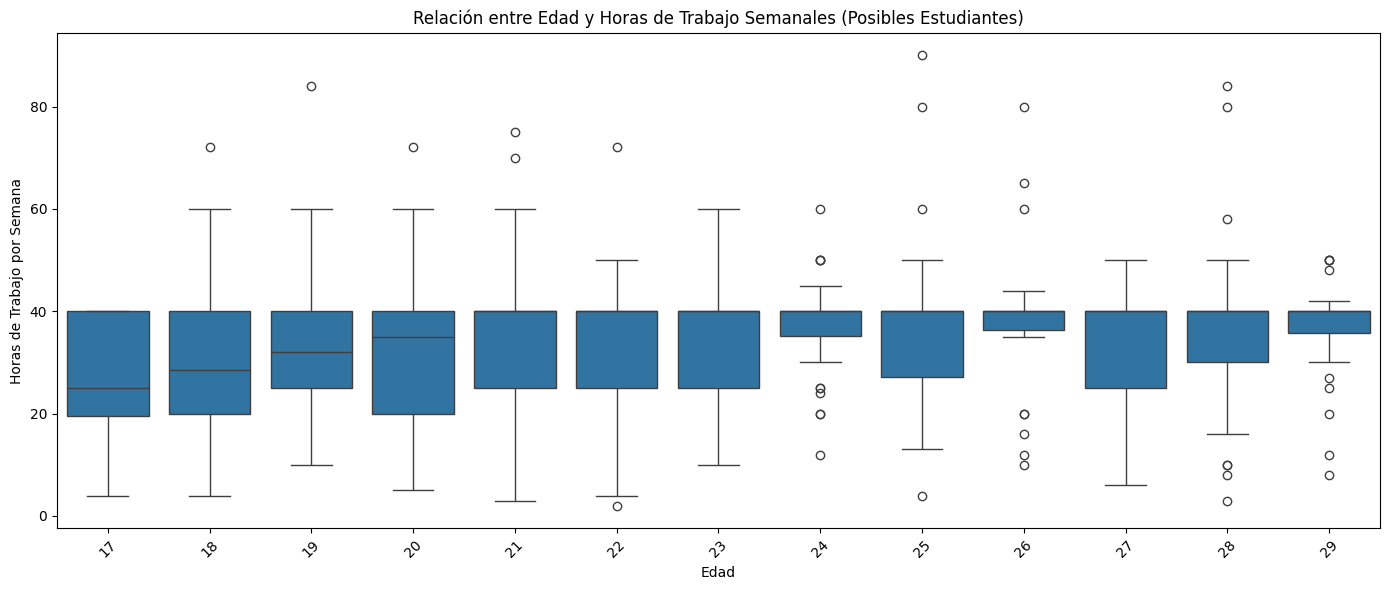

In [27]:
# Crea un diagrama de caja (boxplot) que muestra la distribución de horas trabajadas por semana según la edad
plt.figure(figsize=(14, 6))
sns.boxplot(data=posibles_estudiantes, x="age", y="hours.per.week")
plt.title("Relación entre Edad y Horas de Trabajo Semanales (Posibles Estudiantes)")
plt.xlabel("Edad")
plt.ylabel("Horas de Trabajo por Semana")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

En promedio se considera que un estudiante invierte entre 20 y 35 horas semanales a estudiar. Si se observa el grafico se puede ver que la mayoría de las personas entre los 17 y los 23 años poseen entre 20 y 40 horas de trabajo semanal. A partir de los 24 años, la cantidad de horas de ocupación semanal varía considerablemente, lo que puede sugerir que son personas trabajando de forma informal. Los *outliers* por debajo podría ser considerados desemplados, mientras que los que están por arriba definitivamente trabajan de manera informal.

Un aspecto importante a considerar es el ingreso de estas personas de acuerdo a la edad.

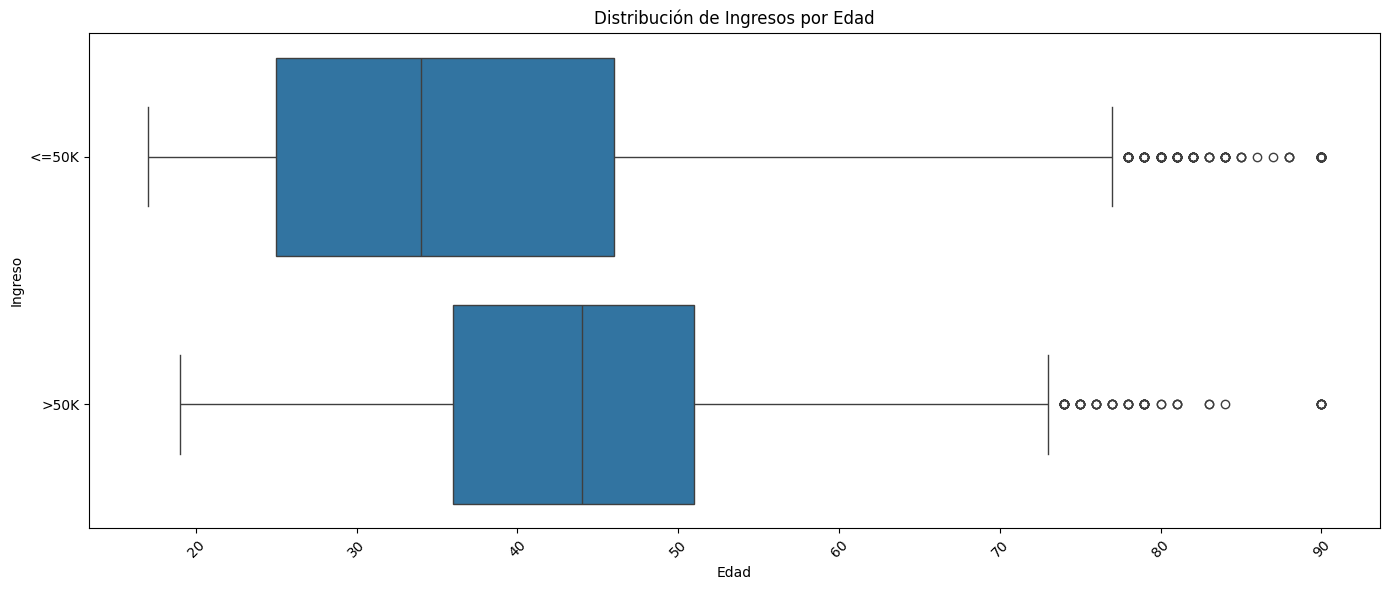

In [28]:
# Crear un boxplot con la edad en el eje X y la categoría de ingreso en el eje Y
plt.figure(figsize=(14, 6))
sns.boxplot(data=census_limpio, x="age", y="income", order=["<=50K", ">50K"])
plt.title("Distribución de Ingresos por Edad")
plt.xlabel("Edad")
plt.ylabel("Ingreso")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

En este gráfico nuevamente se observa algo interesante. Los adultos con ingresos superiores a 50K normalmente poseen más de 35 años, mientras que las personas en este subset con ingresos menores principalmente tienen 25 años y superan los 45 años. Por lo que podemos decir que no son estudiantes, sino personas con trabajo informal.

En base a esta información se crearán tres categorías para los atributos ``occupation`` y ``workclass`` que serán:
- ``student`` para personas entre 17 y 22 años, con categoría educativa de ``Some-collage``, que posean ingresos <=50K y cuya cantidad de horas semanales sea entre 20 y 40.
- ``informal`` para personas de cualquier edad, sin importar la categoría educativa (excepto ``Some-collage``), que posean una cantidad de horas semanales superior a 25.
- ``unemployed`` para personas de cualquier edad, sin importar la categoría educativa (excepto ``Some-collage``), que posean menos de 25 horas semanales.

Cualquier persona que aún después de este completado posea **?** en el atributo ``occupation`` o ``workclass`` serán eliminados del dataset.

In [29]:
# Aplicar condiciones SOLO a las filas con '?' en occupation y workclass
filtro = (census_limpio['occupation'] == '?') & (census_limpio['workclass'] == '?')

# Condición para 'student'
cond_student = (
    filtro &
    (census_limpio['age'].between(17, 22)) &
    (census_limpio['education'] == 'Some-college') &
    (census_limpio['income'] == '<=50K') &
    (census_limpio['hours.per.week'].between(20, 40))
)

# Condición para 'informal'
cond_informal = (
    filtro &
    (census_limpio['hours.per.week'] > 25)
)

# Condición para 'unemployed'
cond_unemployed = (
    filtro &
    (census_limpio['hours.per.week'] < 25)
)

# Asignar nuevas categorías
census_limpio.loc[cond_student, ['occupation', 'workclass']] = 'student'
census_limpio.loc[cond_informal, ['occupation', 'workclass']] = 'informal'
census_limpio.loc[cond_unemployed, ['occupation', 'workclass']] = 'unemployed'

# Eliminar cualquier fila que aún tenga '?' en occupation y workclass
census_limpio = census_limpio[~((census_limpio['occupation'] == '?') & (census_limpio['workclass'] == '?'))]

# Verificación: mostrar nuevas categorías
print(census_limpio[['occupation', 'workclass']].value_counts())

occupation         workclass  
Craft-repair       Private        3195
Sales              Private        2942
Adm-clerical       Private        2833
Other-service      Private        2740
Exec-managerial    Private        2691
                                  ... 
Craft-repair       Without-pay       1
Other-service      Without-pay       1
Machine-op-inspct  Without-pay       1
Handlers-cleaners  Without-pay       1
Transport-moving   Without-pay       1
Name: count, Length: 85, dtype: int64


### Búsqueda y Eliminado de Outliers

El proceso de identificar outliers y eliminarlos inicio en las secciones previas, en las cuales se eliminaron las instancias que poseían la categoría ``Never-worked`` en el atributo ``workclass``. El siguiente paso es encontrar otras inconsistencias que indiquen qué instancias deberían ser eliminadas antes de entrenar un modelo.

- Se verificará si existen personas cuya ``ocupation`` sea ``Unemloyed`` con ingresos mayores a 50K. En caso que existan, serán eliminadas del dataset para evitar que confundan el modelo. Lo mismo será tenido en cuenta para personas con la categoría ``Without-pay`` en su atributo ``workclass`` e ingresos mayores a 50K. Esto puede causar que un modelo no sea capaz de clasificar correctamente una nueva instancia con estas categorías.

- Se verificará si hay personas con la categoría ``Retired`` e ingresos mayores a 50K. Si bien existe la posibilidad de personas retiradas con ese ingreso, se asume que son una porción pequeña de la población, y que retirar dichas instancias permitirá al modelo clasificar con mayor presición.

- Se verificará que no existan estudiantes con ingresos superiores a 50K, lo cual sería otra inconsistencia que podría causar que un modelo de calificación no arroje los resultados esperados.

In [30]:
# Filtro para ingresos mayores a 50K
filtro_ingresos_altos = census_limpio['income'] == '>50K'

# Filtro para occupation igual a 'Unemployed' o workclass igual a 'Without-pay'
filtro_invalido = (census_limpio['occupation'] == 'Unemployed') | (census_limpio['workclass'] == 'Without-pay')

# Aplicar ambos filtros
inconsistencias = census_limpio[filtro_ingresos_altos & filtro_invalido]

# Mostrar resultados
print(f"Número de personas con ingresos >50K y desempleados: {len(inconsistencias)}")


Número de personas con ingresos >50K y desempleados: 0


Ya que no se registran personas con esta inconsistencia, todas las personas con las categorías ``Unemployed`` y ``Without-pay`` poseen un ingreso menor a 50K, lo cual es apropiado para el entrenamiento de este modelo.

In [31]:
# Filtrar personas con occupation 'Retired' e income >50K
filtro_retired_con_ingresos_altos = (census_limpio['occupation'] == 'Retired') & (census_limpio['income'] == '>50K')

# Aplicar ambos filtros
inconsistencias = census_limpio[filtro_retired_con_ingresos_altos]

# Mostrar resultados
print(f"Número de personas con ingresos >50K y jubilados: {len(inconsistencias)}")
display(inconsistencias)


Número de personas con ingresos >50K y jubilados: 65


,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
114,72,Retired,118902,Doctorate,16,Married-civ-spouse,Retired,Husband,White,Male,0,2392,6,United-States,>50K
133,65,Retired,240857,Bachelors,13,Married-civ-spouse,Retired,Husband,White,Male,0,2377,40,United-States,>50K
136,68,Retired,257269,Bachelors,13,Married-civ-spouse,Retired,Husband,White,Male,0,2377,35,United-States,>50K
230,66,Retired,177351,Bachelors,13,Married-civ-spouse,Retired,Husband,White,Male,0,2174,40,United-States,>50K
987,66,Retired,213149,Some-college,10,Married-civ-spouse,Retired,Husband,White,Male,0,1825,40,United-States,>50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30299,68,Retired,108683,Some-college,10,Married-civ-spouse,Retired,Wife,White,Female,0,0,12,United-States,>50K
31348,64,Retired,208862,HS-grad,9,Married-civ-spouse,Retired,Husband,White,Male,0,0,50,United-States,>50K
31707,72,Retired,108796,Prof-school,15,Married-civ-spouse,Retired,Husband,White,Male,0,0,40,United-States,>50K
31799,90,Retired,313986,HS-grad,9,Married-civ-spouse,Retired,Husband,White,Male,0,0,40,United-States,>50K


En total se encuentran 65 personas jubiladas con ingresos superiores a 50K, de un total de 415 personas etiquetadas como ``retired``. Dado que al momento de entrenar un clasificador esta categoría puede causar que dicho clasificador no funcione correctamente, vamos a eliminar estas instancias, y asumir que la mayoría de las personas que están jubiladas normalmente poseen ingresos inferiores a 50K.

In [32]:
# Mostrar cuántas personas serán eliminadas
print(f"Cantidad de personas eliminadas: {filtro_retired_con_ingresos_altos.sum()}")

# Eliminar esas filas del dataset
census_limpio = census_limpio[~filtro_retired_con_ingresos_altos].copy()

Cantidad de personas eliminadas: 65


In [33]:
# Filtrar personas con occupation o workclass igual a 'student' e ingresos >50K
filtro_estudiantes_con_ingresos_altos = (
    ((census_limpio['occupation'] == 'student') | (census_limpio['workclass'] == 'student')) &
    (census_limpio['income'] == '>50K')
)

# Mostrar cuántas personas cumplen esta condición
cantidad_estudiantes_ingresos_altos = filtro_estudiantes_con_ingresos_altos.sum()
print(f"Cantidad de personas clasificadas como estudiantes con ingresos >50K: {cantidad_estudiantes_ingresos_altos}")

# Mostrar esas instancias si existen
if cantidad_estudiantes_ingresos_altos > 0:
    display(census_limpio[filtro_estudiantes_con_ingresos_altos])
else:
    print("No se encontraron estudiantes con ingresos superiores a 50K.")

Cantidad de personas clasificadas como estudiantes con ingresos >50K: 0
No se encontraron estudiantes con ingresos superiores a 50K.


No se detectan estudiantes con ingresos tan altos, lo cual es consistente. La mayoría de los estudiantes se dedican tiempo completo a sus estudios, o poseen trabajos con salarios bajos. El dataset ya modificado parece ser congruente con esta realidad.

Finalmente se eliminarán atributos con baja correlación, tales como:
- ``fnlwgt``
- ``education`` ya que exite el atributo ``education.num``
- ``race``
- ``native.country``

In [34]:
# Atributos a eliminar
columnas_a_remover = ['fnlwgt', 'education', 'race', 'native-country']

# Asegurate de usar el nombre correcto de las columnas (revisá si es 'native-country' o 'native country')
census_limpio = census_limpio.drop(columns=columnas_a_remover, errors='ignore')

# Confirmar
print("Columnas eliminadas. Dimensiones actuales:", census_limpio.shape)
print("Columnas actuales:", census_limpio.columns.tolist())


Columnas eliminadas. Dimensiones actuales: (32433, 12)
Columnas actuales: ['age', 'workclass', 'education.num', 'marital.status', 'occupation', 'relationship', 'sex', 'capital.gain', 'capital.loss', 'hours.per.week', 'native.country', 'income']


## Generación de Train Set y Test Set

Habiendo dejado el dataset completo y sin *outliers*, se procede a separar el mismo en un set de entrenamiento (*train set*) y uno de testeo (*test set*). Para mantener la misma proporción de personas con ingresos por arriba y por debajo de 50K en ambos sets, es que se toma esta etiqueta para estratificar, y que posean la misma cantidad de instancias originalmente clasificadas con estas etiquetas.

Además se aplicará ``OneHotEncoding`` para convertir los atributos categóricos en numéricos, y se aplicará un ``StandardScaler`` a todos los atributos numéricos.

In [35]:
# Separar variables predictoras (X) y variable objetivo (y)
X = census_limpio.drop(columns=['income'])
y = census_limpio['income']

# División estratificada
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Calcular proporciones
proporciones = pd.DataFrame({
    'Dataset Completo': y.value_counts(normalize=True),
    'Train Set': y_train.value_counts(normalize=True),
    'Test Set': y_test.value_counts(normalize=True)
})

# Convertir a porcentajes
proporciones = proporciones.map(lambda x: f"{x:.2%}")

# Mostrar tabla
print(proporciones)

# Separar columnas categóricas y numéricas
categorical_features = X_train.select_dtypes(include='object').columns.tolist()
numerical_features = X_train.select_dtypes(exclude='object').columns.tolist()

# Crear el preprocesador
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('num', StandardScaler(), numerical_features)
])

       Dataset Completo Train Set Test Set
income                                    
<=50K            76.03%    76.03%   76.03%
>50K             23.97%    23.97%   23.97%


Como se puede observar, ambos datasets poseen la misma proporción de personas con ingresos <=50K y >50K, respecto del dataset original luego de haber sido completado y se eliminaron los *outliers*. Otro aspecto importante a notar es que el dataset está desbalanceado, ya que hay muchas más personas con ingresos <=50K que mayores a 50K.

## Selección de Modelos y Entrenamiento

Con el fin de predecir si una persona obtiene ingresos mayores a 50K anuales, se evaluarán los siguientes modelos de clasificación supervisada:

1. **Regresión Logística**: Modelo base para clasificación binaria, útil como referencia inicial.

2. **Árboles de Decisión (Decision Tree Classifier)**: Permite interpretar decisiones basadas en reglas y condiciones.

3. **Random Forest**: Ensamble de árboles de decisión que mejora la generalización y reduce el overfitting.

4. **Gradient Boosting (XGBoost o GradientBoostingClassifier)**: Modelo basado en boosting, que corrige los errores de modelos anteriores.

5. **Support Vector Machines (SVM)**: Eficiente en espacios de alta dimensión, especialmente con kernels no lineales.

6. **K-Nearest Neighbors (KNN)**: Modelo basado en la similitud de instancias vecinas, útil para entender la estructura local.


### Métricas de Evaluación

Cada modelo será evaluado utilizando las siguientes métricas de rendimiento:

- **Accuracy (Exactitud)**: Proporción de predicciones correctas sobre el total de instancias.

- **Precision (Precisión)**: Proporción de verdaderos positivos sobre el total de predicciones positivas realizadas.

- **Recall (Sensibilidad o Tasa de Verdaderos Positivos)**: Proporción de verdaderos positivos sobre el total de instancias realmente positivas.

- **F1-Score**: Media armónica entre precisión y recall, útil ante clases desbalanceadas.

- **Matriz de Confusión**: Visualización de los aciertos y errores del modelo en cada clase.

Estas métricas permitirán una comparación exhaustiva entre modelos, favoreciendo tanto el rendimiento como la interpretación en contextos donde el costo de una clasificación errónea puede ser relevante. Se implementa una función para generar todas las métricas con las que se evaluarán los modelos.

In [36]:
def model_eval(nombre_modelo, y_true, y_pred, y_proba=None):
    """
    Evalúa un modelo de clasificación e imprime métricas clave,
    un reporte detallado por clase, la matriz de confusión,
    y curvas de precisión y recall vs. umbral por clase si se proporcionan probabilidades.

    Parámetros:
    - nombre_modelo: str, nombre del modelo
    - y_true: array-like, etiquetas reales
    - y_pred: array-like, etiquetas predichas
    - y_proba: array-like (opcional), probabilidades predichas (shape: [n_samples, n_classes])
    """
    import matplotlib.pyplot as plt
    from sklearn.metrics import (
        accuracy_score, precision_score, recall_score, f1_score,
        classification_report, confusion_matrix,
        precision_recall_curve
    )
    import numpy as np
    import seaborn as sns

    # Métricas globales
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    print(f"\n📊 Evaluación del modelo: {nombre_modelo}")
    print(f"🔹 Accuracy:  {acc:.4f}")
    print(f"🔹 Precision: {prec:.4f}")
    print(f"🔹 Recall:    {rec:.4f}")
    print(f"🔹 F1 Score:  {f1:.4f}")

    # Reporte detallado por clase
    print("\n📄 Reporte por clase:")
    print(classification_report(y_true, y_pred, zero_division=0))

    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    labels = sorted(np.unique(y_true))

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(f"Matriz de Confusión: {nombre_modelo}")
    plt.xlabel("Predicción")
    plt.ylabel("Valor Real")
    plt.tight_layout()
    plt.show()

    # Curvas precisión y recall vs. umbral por clase
    if y_proba is not None:
        if y_proba.ndim == 1:
            y_proba = np.vstack([1 - y_proba, y_proba]).T

        clases = np.unique(y_true)
        for i, clase in enumerate(clases):
            binarizado = (y_true == clase).astype(int)
            proba_clase = y_proba[:, i]
            precision, recall, thresholds = precision_recall_curve(binarizado, proba_clase)
            thresholds = np.append(thresholds, 1.0)

            # Umbral por defecto: 0.5
            default_threshold = 0.5

            plt.figure(figsize=(8, 5))
            plt.plot(thresholds, precision, label='Precisión', color='blue')
            plt.plot(thresholds, recall, label='Recall', color='green')
            plt.axvline(default_threshold, color='red', linestyle='--', label=f'Umbral actual ({default_threshold})')

            plt.title(f'Precisión y Recall vs. Umbral (Clase: {clase})')
            plt.xlabel('Umbral')
            plt.ylabel('Valor')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()


### Clasificador de Ingresos con Regresión Logística

En esta etapa se entrena un modelo de clasificación utilizando el algoritmo **Regresión Logística**, un método lineal ampliamente utilizado para tareas de clasificación binaria. El objetivo es predecir si una persona obtiene **ingresos mayores a 50K** (`>50K`) o **iguales o menores a 50K** (`<=50K`) a partir de las características sociodemográficas presentes en el dataset `Adult Census Income`.

#### Configuración del Modelo

El clasificador utilizado es `LogisticRegression` de la librería `scikit-learn`, con la siguiente configuración de hiperparámetros:

| Parámetro        | Valor             | Descripción                                                                  |
|------------------|-------------------|------------------------------------------------------------------------------|
| `penalty`        | `'l2'`            | Tipo de regularización (Ridge), que evita el sobreajuste.                   |
| `solver`         | `'liblinear'`     | Algoritmo de optimización apropiado para datasets pequeños y medianos.      |
| `max_iter`       | `1000`            | Número máximo de iteraciones permitidas para la convergencia.               |
| `random_state`   | `42`              | Semilla aleatoria para asegurar reproducibilidad.                           |

Este modelo sirve como una línea base sólida y fácilmente interpretable, permitiendo identificar qué variables tienen mayor influencia en la predicción de los ingresos.

#### Guardado del Modelo

El modelo entrenado se guarda en el archivo:
```
logistic_income_classifier.pkl
```
Este archivo puede ser reutilizado para realizar predicciones o evaluaciones con nuevos datos o conjuntos de prueba.

In [37]:
# Construir el pipeline
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('classifier', LogisticRegression(
        penalty='l2',
        solver='liblinear',
        max_iter=1000,
        random_state=42
    ))
])

# Entrenar el pipeline completo
pipeline.fit(X_train, y_train)

# Guardar el modelo entrenado
output_model_path = "logistic_income_classifier.pkl"
joblib.dump(pipeline, output_model_path)

print(f"✅ Modelo de Regresión Logística guardado en: {output_model_path}")

✅ Modelo de Regresión Logística guardado en: logistic_income_classifier.pkl



📊 Evaluación del modelo: Logistic Regression Classifier
🔹 Accuracy:  0.8488
🔹 Precision: 0.8424
🔹 Recall:    0.8488
🔹 F1 Score:  0.8438

📄 Reporte por clase:
              precision    recall  f1-score   support

       <=50K       0.88      0.93      0.90      4932
        >50K       0.72      0.60      0.66      1555

    accuracy                           0.85      6487
   macro avg       0.80      0.76      0.78      6487
weighted avg       0.84      0.85      0.84      6487



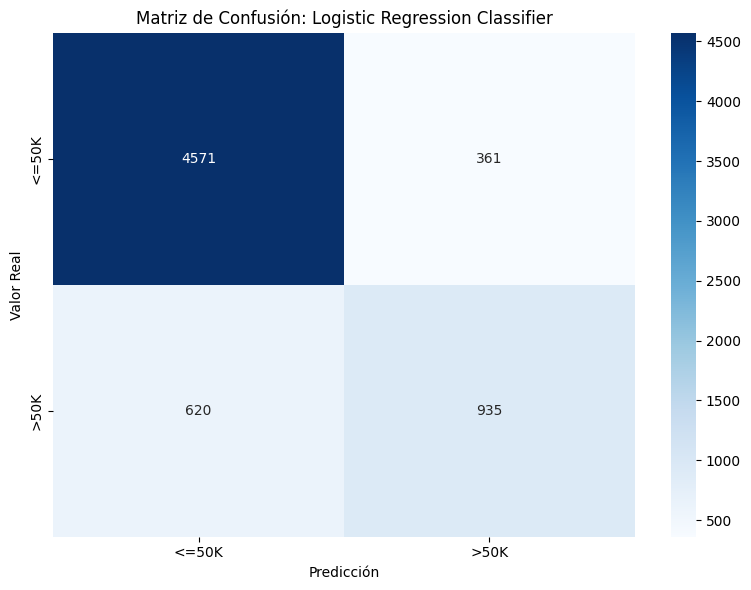

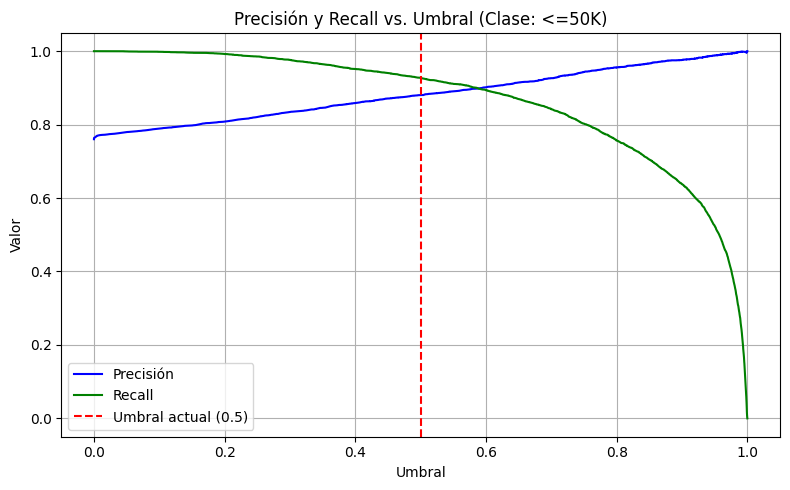

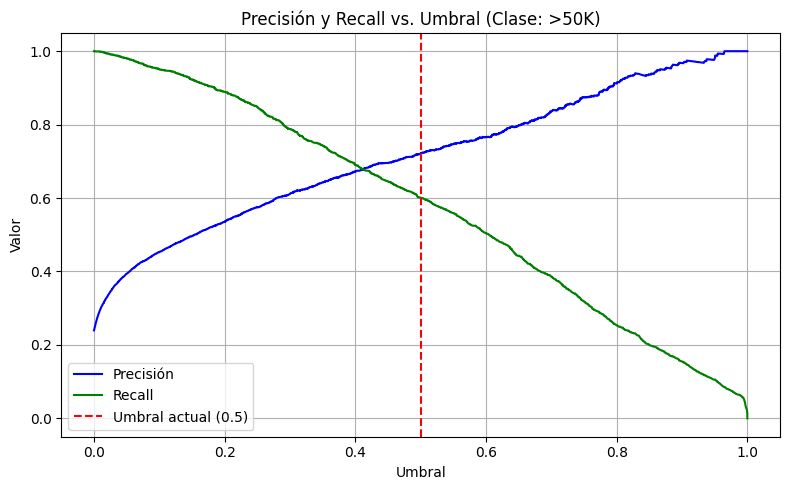

In [38]:
# Cargar el modelo desde el archivo
lr_model = joblib.load("logistic_income_classifier.pkl")

# Predecir valores usando el model
y_pred_lr = lr_model.predict(X_test)

# Calcular probabilidades del modelo por clase
y_proba_lr = lr_model.predict_proba(X_test)

# Evaluar modelo
model_eval("Logistic Regression Classifier", y_test, y_pred_lr, y_proba_lr)

### Clasificador de Ingresos con Árbol de Decisión

En esta etapa se entrena un modelo de clasificación utilizando el algoritmo **Árbol de Decisión**, una técnica interpretable que permite dividir iterativamente los datos en función de los atributos más relevantes. El objetivo es predecir si una persona obtiene **ingresos mayores a 50K** (`>50K`) o **iguales o menores a 50K** (`<=50K`) a partir de sus características personales y laborales.

#### Configuración del Modelo

El clasificador utilizado es `DecisionTreeClassifier` de la librería `scikit-learn`, con la siguiente configuración de hiperparámetros:

| Parámetro        | Valor             | Descripción                                                                 |
|------------------|-------------------|-----------------------------------------------------------------------------|
| `criterion`      | `'gini'`          | Función para medir la calidad de una división (impureza de Gini).          |
| `max_depth`      | `None`            | No se limita la profundidad del árbol, lo que permite que crezca libremente.|
| `random_state`   | `42`              | Semilla aleatoria para asegurar reproducibilidad.                          |

Este modelo es especialmente útil para explorar reglas de decisión claras y visualizar cómo se toman las decisiones a partir de los atributos. Aunque puede sobreajustar si no se controla la profundidad, es una excelente herramienta para análisis exploratorio e interpretación de resultados.

#### Guardado del Modelo

El modelo entrenado se guarda en el archivo:
```
decision_tree_income_classifier.pkl
```
Este archivo puede ser cargado posteriormente para realizar predicciones, evaluaciones con nuevos datos o incluso para visualizar la estructura del árbol de decisión.

In [39]:
# Construir el pipeline
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('classifier', DecisionTreeClassifier(
        criterion='gini',
        max_depth=None,
        random_state=42
    ))
])

# Entrenar el pipeline completo
pipeline.fit(X_train, y_train)

# Guardar el modelo entrenado
output_model_path = "decision_tree_income_classifier.pkl"
joblib.dump(pipeline, output_model_path)

print(f"✅ Modelo Decision Tree guardado en: {output_model_path}")

✅ Modelo Decision Tree guardado en: decision_tree_income_classifier.pkl



📊 Evaluación del modelo: Decision Tree Classifier
🔹 Accuracy:  0.8247
🔹 Precision: 0.8217
🔹 Recall:    0.8247
🔹 F1 Score:  0.8231

📄 Reporte por clase:
              precision    recall  f1-score   support

       <=50K       0.88      0.89      0.89      4932
        >50K       0.64      0.61      0.62      1555

    accuracy                           0.82      6487
   macro avg       0.76      0.75      0.76      6487
weighted avg       0.82      0.82      0.82      6487



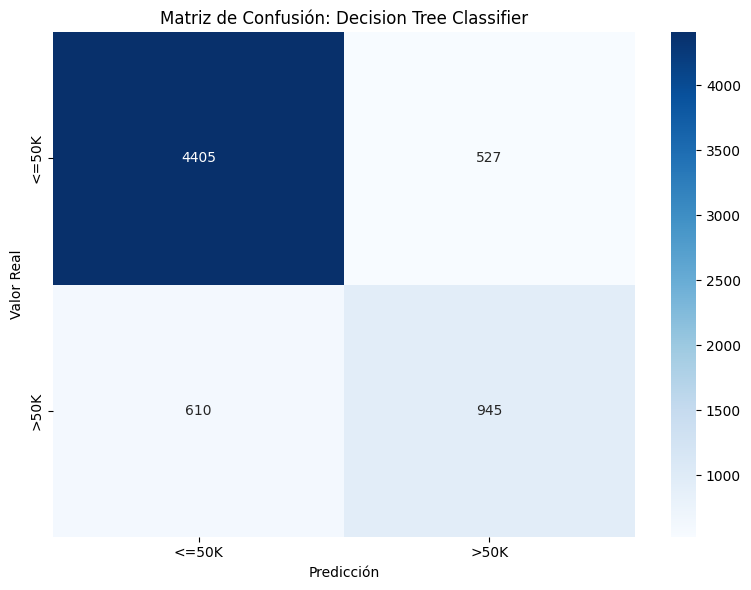

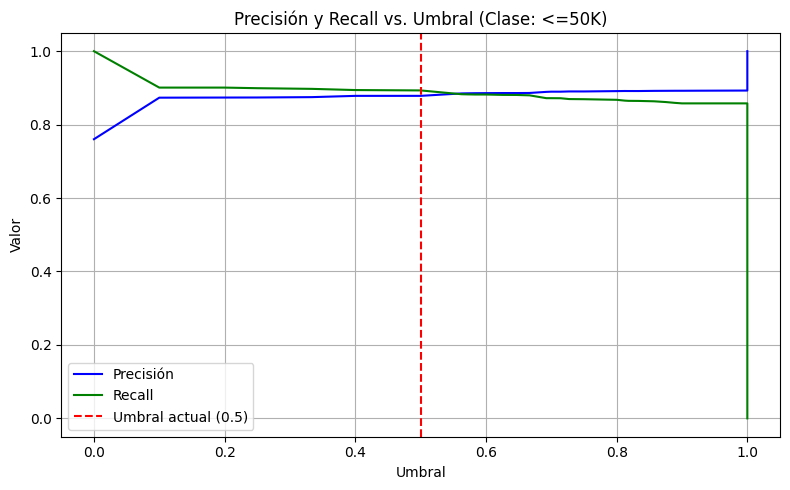

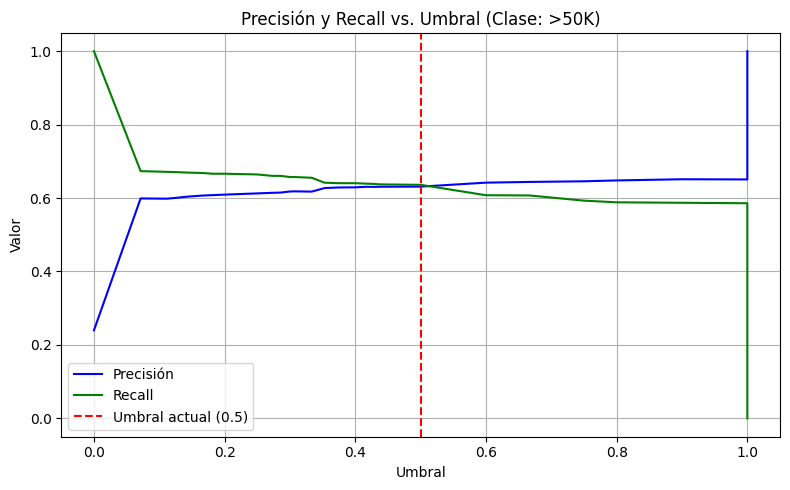

In [40]:
# Cargar el modelo desde el archivo
dt_model = joblib.load("decision_tree_income_classifier.pkl")

# Predecir valores usando el model
y_pred_dt = dt_model.predict(X_test)

# Calcular probabilidades del modelo por clase
y_proba_dt = dt_model.predict_proba(X_test)

# Evaluar modelo
model_eval("Decision Tree Classifier", y_test, y_pred_dt, y_proba_dt)

### Clasificador de Ingresos con Random Forest

En esta etapa se entrena un modelo de clasificación utilizando el algoritmo **Random Forest**, un método de ensamble que construye múltiples árboles de decisión y combina sus predicciones para mejorar la precisión y reducir el sobreajuste. El objetivo es predecir si una persona obtiene **ingresos mayores a 50K** (`>50K`) o **iguales o menores a 50K** (`<=50K`) utilizando las variables sociodemográficas del dataset `Adult Census Income`.

#### Configuración del Modelo

El clasificador utilizado es `RandomForestClassifier` de la librería `scikit-learn`, con la siguiente configuración de hiperparámetros:

| Parámetro        | Valor             | Descripción                                                                 |
|------------------|-------------------|-----------------------------------------------------------------------------|
| `n_estimators`   | `100`             | Número de árboles que componen el bosque aleatorio.                        |
| `max_depth`      | `None`            | Los árboles crecen hasta sobreajustarse si no se limita la profundidad.    |
| `random_state`   | `42`              | Semilla aleatoria para garantizar resultados reproducibles.                |
| `n_jobs`         | `-1`              | Utiliza todos los núcleos de CPU disponibles para acelerar el entrenamiento.|

Este modelo es particularmente robusto ante valores atípicos y relaciones no lineales, y es ideal para obtener buen rendimiento en tareas de clasificación con múltiples características heterogéneas.

#### Guardado del Modelo

El modelo entrenado se guarda en el archivo:
```
random_forest_income_classifier.pkl
```
Este archivo puede utilizarse posteriormente para realizar predicciones o evaluaciones sobre datos nuevos o del conjunto de prueba.

In [41]:
rf_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    ))
])

rf_pipeline.fit(X_train, y_train)

output_model_path = "random_forest_income_classifier.pkl"
joblib.dump(rf_pipeline, output_model_path)

print(f"✅ Modelo Random Forest guardado en: {output_model_path}")

✅ Modelo Random Forest guardado en: random_forest_income_classifier.pkl



📊 Evaluación del modelo: Random Forest Classifier
🔹 Accuracy:  0.8437
🔹 Precision: 0.8382
🔹 Recall:    0.8437
🔹 F1 Score:  0.8400

📄 Reporte por clase:
              precision    recall  f1-score   support

       <=50K       0.88      0.92      0.90      4932
        >50K       0.70      0.61      0.65      1555

    accuracy                           0.84      6487
   macro avg       0.79      0.76      0.78      6487
weighted avg       0.84      0.84      0.84      6487



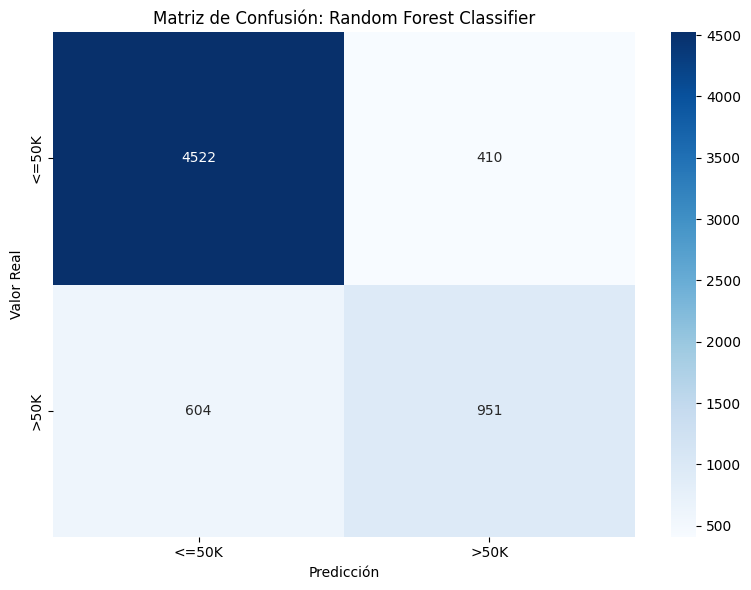

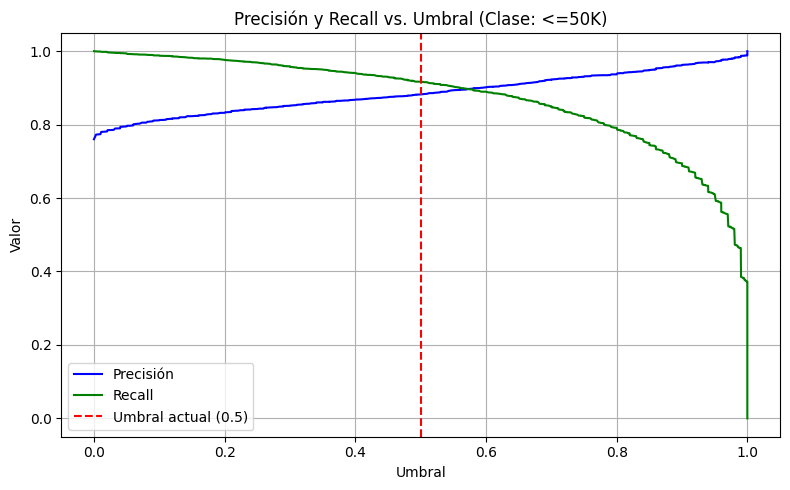

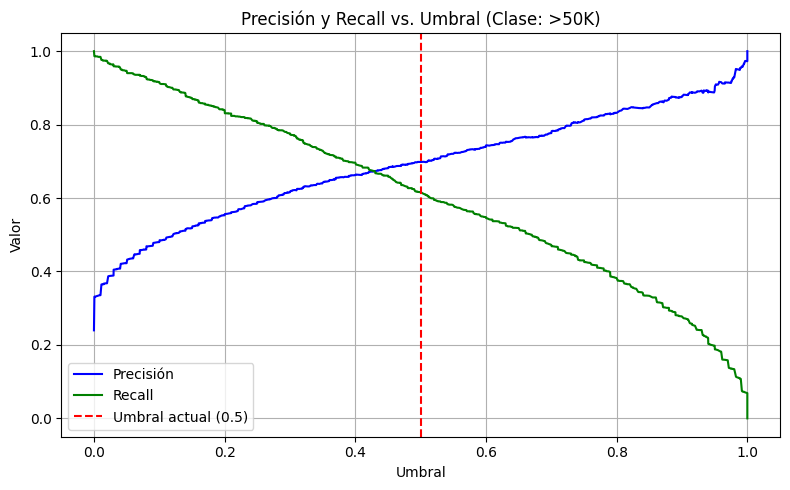

In [42]:
# Cargar el modelo desde el archivo
rf_model = joblib.load("random_forest_income_classifier.pkl")

# Predecir valores usando el model
y_pred_rf = rf_model.predict(X_test)

# Calcular probabilidades del modelo por clase
y_proba_rf = rf_model.predict_proba(X_test)

# Evaluar modelo
model_eval("Random Forest Classifier", y_test, y_pred_rf, y_proba_rf)

### Clasificador de Ingresos con XGBoost

En esta etapa se entrena un modelo de clasificación utilizando el algoritmo **XGBoost** (Extreme Gradient Boosting), un método basado en árboles de decisión con boosting que optimiza la precisión mediante la corrección iterativa de errores. El objetivo es predecir si una persona obtiene **ingresos mayores a 50K** (`>50K`) o **iguales o menores a 50K** (`<=50K`) usando las variables sociodemográficas del dataset `Adult Census Income`.

#### Configuración del Modelo

El clasificador utilizado es `XGBClassifier` de la librería `xgboost`, con la siguiente configuración de hiperparámetros:

| Parámetro          | Valor   | Descripción                                                                 |
|--------------------|---------|-----------------------------------------------------------------------------|
| `n_estimators`     | `100`   | Número de árboles en el modelo.                                             |
| `max_depth`        | `6`     | Profundidad máxima de cada árbol.                                          |
| `learning_rate`    | `0.1`   | Tasa de aprendizaje para actualización de pesos.                          |
| `random_state`     | `42`    | Semilla aleatoria para reproducibilidad.                                  |
| `use_label_encoder`| `False` | Evita aviso de depreciación del encoder de etiquetas interno.              |
| `eval_metric`      | `'logloss'` | Métrica de evaluación durante el entrenamiento.                         |

#### Guardado del Modelo

El modelo entrenado se guarda en el archivo:
```
xgboost_income_classifier.pkl
```

In [43]:
# Convertir etiquetas de texto a 0 y 1
y_train_bin = (y_train == '>50K').astype(int)
y_test_bin = (y_test == '>50K').astype(int)

xgb_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('classifier', XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    ))
])

xgb_pipeline.fit(X_train, y_train_bin)

joblib.dump(xgb_pipeline, "xgboost_income_classifier.pkl")
print("✅ Modelo XGBoost guardado en: xgboost_income_classifier.pkl")

d:\adult_census_income\env\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:59:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Modelo XGBoost guardado en: xgboost_income_classifier.pkl



📊 Evaluación del modelo: Gradient Boosting Classifier
🔹 Accuracy:  0.8677
🔹 Precision: 0.8626
🔹 Recall:    0.8677
🔹 F1 Score:  0.8626

📄 Reporte por clase:
              precision    recall  f1-score   support

           0       0.89      0.94      0.92      4932
           1       0.78      0.63      0.69      1555

    accuracy                           0.87      6487
   macro avg       0.83      0.79      0.81      6487
weighted avg       0.86      0.87      0.86      6487



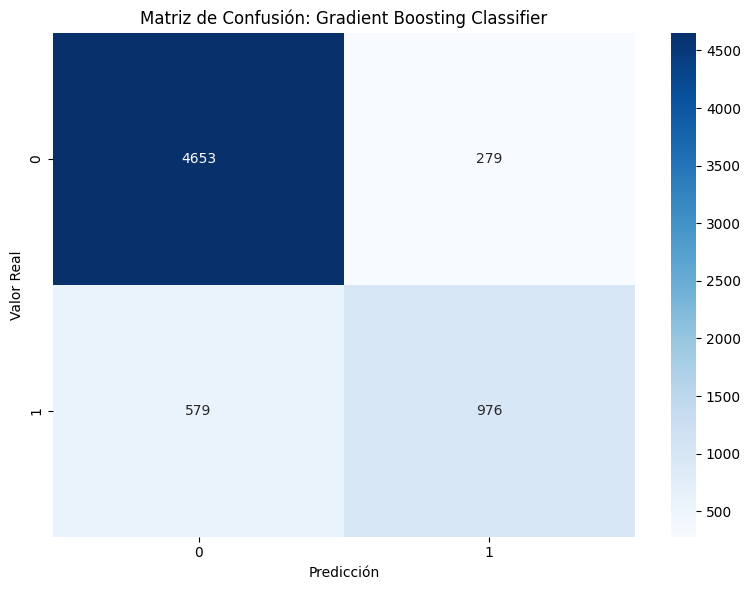

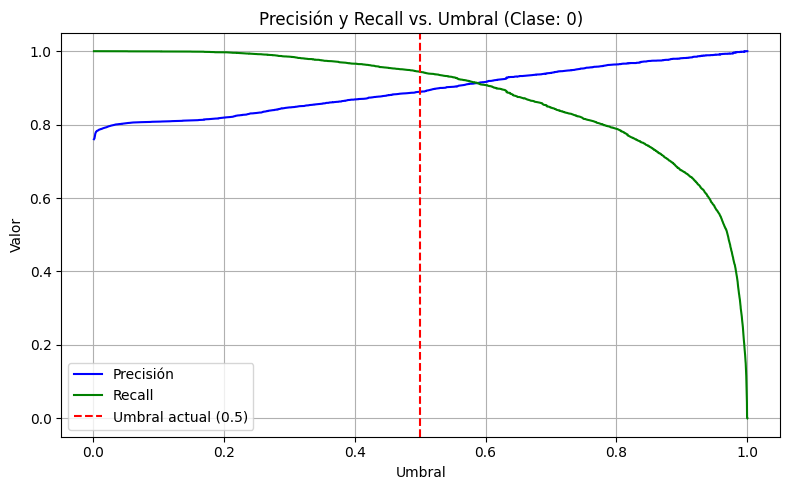

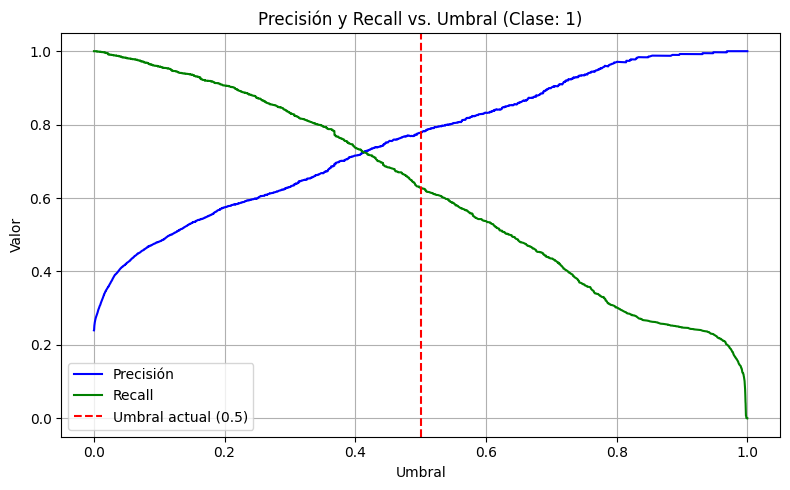

In [44]:
# Cargar el modelo desde el archivo
xgb_model = joblib.load("xgboost_income_classifier.pkl")

# Predecir valores usando el model
y_pred_xgb = xgb_model.predict(X_test)

# Calcular probabilidades del modelo por clase
y_proba_xgb = xgb_model.predict_proba(X_test)

# Evaluar modelo
model_eval("Gradient Boosting Classifier", y_test_bin, y_pred_xgb, y_proba_xgb)

### Clasificador de Ingresos con SVM (Support Vector Machine)

Se entrena un modelo utilizando el algoritmo **Support Vector Machine** (SVM), que busca un hiperplano que separe las clases maximizando el margen entre ellas. Este método es eficiente para clasificación binaria y funciona bien en espacios de alta dimensión.

#### Configuración del Modelo

El clasificador utilizado es `SVC` de la librería `scikit-learn`, con la siguiente configuración de hiperparámetros:

| Parámetro        | Valor          | Descripción                                                          |
|------------------|----------------|----------------------------------------------------------------------|
| `kernel`         | `'rbf'`        | Núcleo radial para capturar relaciones no lineales.                  |
| `C`              | `1.0`          | Parámetro de regularización que controla el equilibrio sesgo-varianza. |
| `gamma`          | `'scale'`      | Coeficiente para el kernel RBF que ajusta la influencia de puntos.   |
| `random_state`   | `42`           | Semilla para reproducibilidad.                                       |

#### Guardado del Modelo

El modelo entrenado se guarda en el archivo:
```
svm_income_classifier.pkl
```

In [45]:
svm_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('classifier', SVC(
        kernel='rbf',
        C=1.0,
        gamma='scale',
        random_state=42,
        probability=True 
    ))
])

svm_pipeline.fit(X_train, y_train)

joblib.dump(svm_pipeline, "svm_income_classifier.pkl")
print("✅ Modelo SVM guardado en: svm_income_classifier.pkl")

✅ Modelo SVM guardado en: svm_income_classifier.pkl



📊 Evaluación del modelo: Support Vector machine Classifier
🔹 Accuracy:  0.8534
🔹 Precision: 0.8469
🔹 Recall:    0.8534
🔹 F1 Score:  0.8478

📄 Reporte por clase:
              precision    recall  f1-score   support

       <=50K       0.88      0.93      0.91      4932
        >50K       0.74      0.60      0.66      1555

    accuracy                           0.85      6487
   macro avg       0.81      0.77      0.78      6487
weighted avg       0.85      0.85      0.85      6487



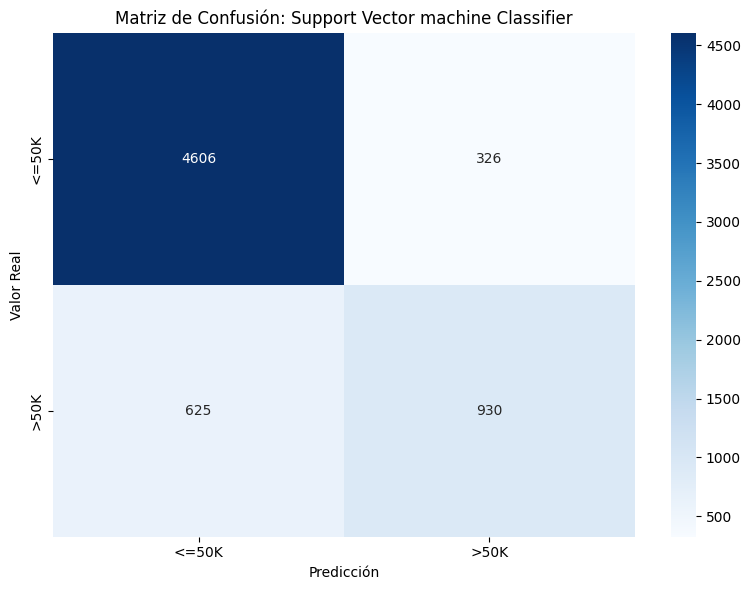

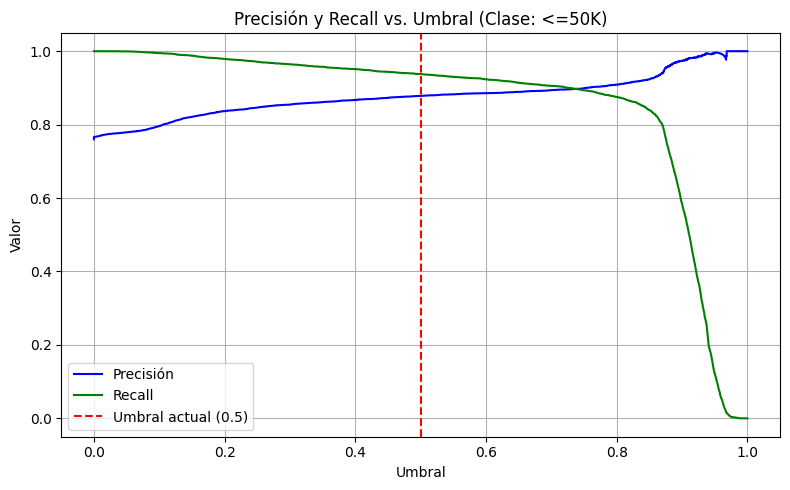

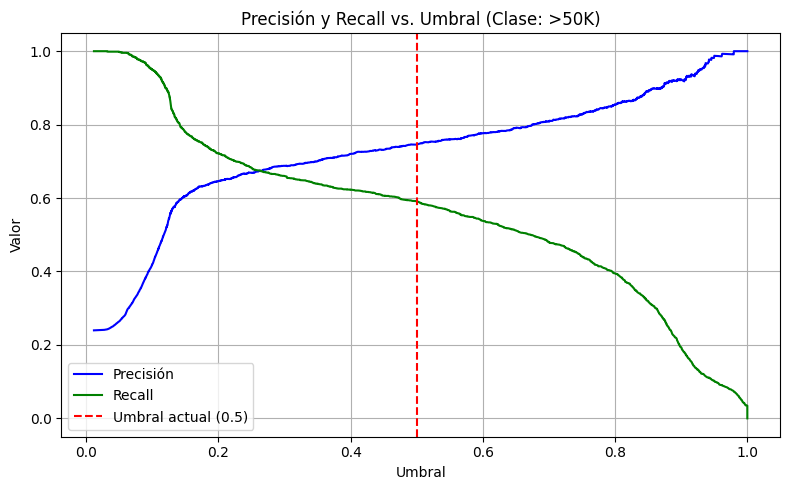

In [46]:
# Cargar el modelo desde el archivo
svm_model = joblib.load("svm_income_classifier.pkl")

# Predecir valores usando el model
y_pred_svm = svm_model.predict(X_test)

# Calcular probabilidades del modelo por clase
y_proba_svm = svm_model.predict_proba(X_test)

# Evaluar modelo
model_eval("Support Vector machine Classifier", y_test, y_pred_svm, y_proba_svm)


### Clasificador de Ingresos con K-Nearest Neighbors (KNN)

En esta etapa se entrena un modelo de clasificación utilizando **K-Nearest Neighbors (KNN)**, que asigna la clase mayoritaria entre los vecinos más cercanos de una instancia basándose en una métrica de distancia. Es simple, intuitivo y efectivo para datos con estructuras bien definidas.

#### Configuración del Modelo

El clasificador utilizado es `KNeighborsClassifier` de la librería `scikit-learn`, con la siguiente configuración de hiperparámetros:

| Parámetro        | Valor   | Descripción                                           |
|------------------|---------|-------------------------------------------------------|
| `n_neighbors`    | `5`     | Número de vecinos a considerar para la predicción.    |
| `weights`        | `'uniform'` | Todos los vecinos tienen el mismo peso en la votación.|
| `algorithm`      | `'auto'` | Selección automática del algoritmo de búsqueda.      |

#### Guardado del Modelo

El modelo entrenado se guarda en el archivo:

```
knn_income_classifier.pkl
```

In [47]:
knn_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('classifier', KNeighborsClassifier(
        n_neighbors=5,
        weights='uniform',
        algorithm='auto'
    ))
])

knn_pipeline.fit(X_train, y_train)

joblib.dump(knn_pipeline, "knn_income_classifier.pkl")
print("✅ Modelo KNN guardado en: knn_income_classifier.pkl")

✅ Modelo KNN guardado en: knn_income_classifier.pkl



📊 Evaluación del modelo: K-Nearest Neighbors Classifier
🔹 Accuracy:  0.8347
🔹 Precision: 0.8298
🔹 Recall:    0.8347
🔹 F1 Score:  0.8317

📄 Reporte por clase:
              precision    recall  f1-score   support

       <=50K       0.88      0.91      0.89      4932
        >50K       0.67      0.61      0.64      1555

    accuracy                           0.83      6487
   macro avg       0.78      0.76      0.77      6487
weighted avg       0.83      0.83      0.83      6487



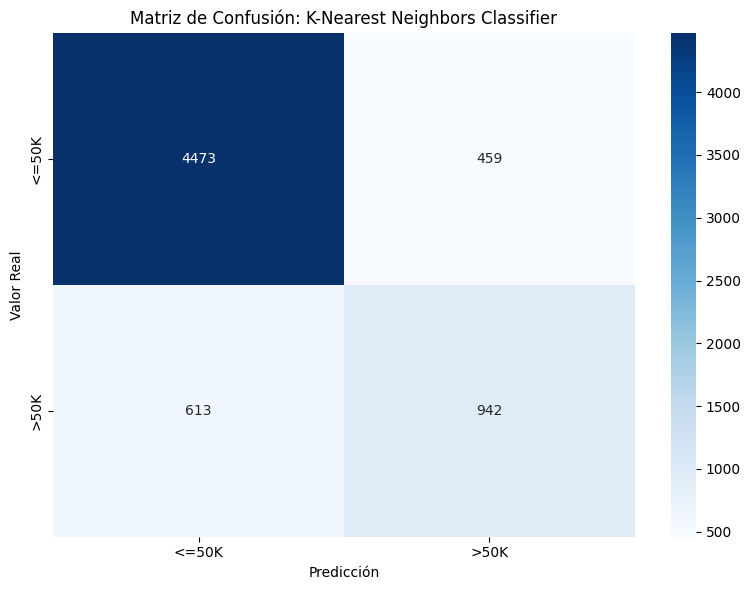

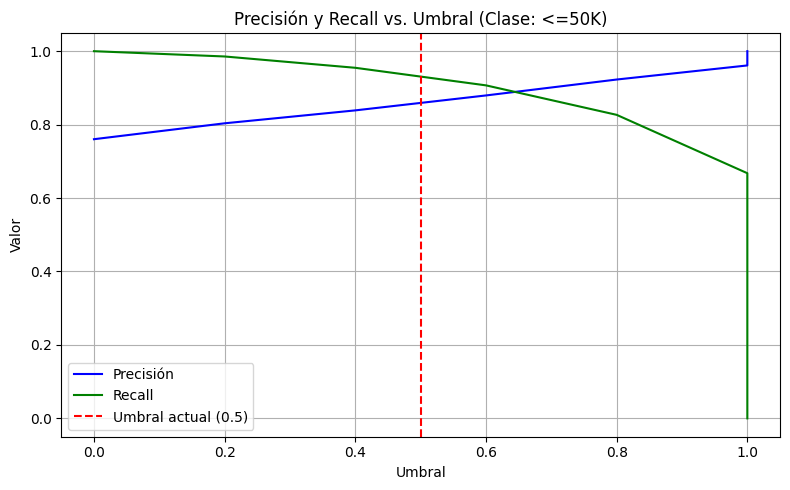

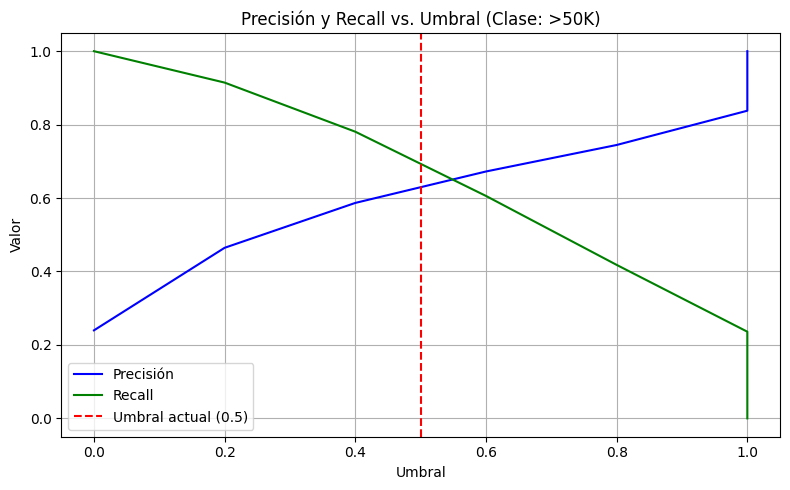

In [48]:
# Cargar el modelo desde el archivo
knn_model = joblib.load("knn_income_classifier.pkl")

# Predecir valores usando el model
y_pred_knn = knn_model.predict(X_test)

# Calcular probabilidades del modelo por clase
y_proba_knn = knn_model.predict_proba(X_test)

# Evaluar modelo
model_eval("K-Nearest Neighbors Classifier", y_test, y_pred_knn, y_proba_knn)

### Comparativa de Modelos Clasificadores

Una vez entrenados y evaluados todos los modelos de clasificación, se procede a comparar su desempeño utilizando las métricas estándar: **Accuracy**, **Precision**, **Recall** y **F1 Score**. Estas métricas ofrecen una visión integral del rendimiento, considerando tanto los errores como los aciertos en la clasificación de ingresos (<=50K y >50K).

A continuación se muestra una tabla resumen con los resultados obtenidos por cada modelo. Esta tabla facilita la identificación del modelo con mejor rendimiento global y ayuda en la toma de decisiones sobre cuál utilizar en producción o análisis posterior.


In [49]:
# Función para extraer el classification report como DataFrame
def report_to_df(y_true, y_pred, model_name, labels):
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0, labels=labels)
    df = pd.DataFrame(report).T
    df = df.loc[[str(label) for label in labels]]  # Filtrar solo las clases
    df['model'] = model_name
    return df.reset_index().rename(columns={'index': 'class'})

# Generar reportes por modelo
reportes = []

# Modelos con etiquetas categóricas
reportes.append(report_to_df(y_test, y_pred_lr, "Logistic Regression", ['<=50K', '>50K']))
reportes.append(report_to_df(y_test, y_pred_dt, "Decision Tree", ['<=50K', '>50K']))
reportes.append(report_to_df(y_test, y_pred_rf, "Random Forest", ['<=50K', '>50K']))
reportes.append(report_to_df(y_test, y_pred_svm, "SVM", ['<=50K', '>50K']))
reportes.append(report_to_df(y_test, y_pred_knn, "KNN", ['<=50K', '>50K']))

# Modelo XGBoost con etiquetas binarias
reportes.append(report_to_df(y_test_bin, y_pred_xgb, "XGBoost", [0, 1]))

# Concatenar todos los reportes
df_metricas_clase = pd.concat(reportes, ignore_index=True)
df_metricas_clase = df_metricas_clase[['model', 'class', 'precision', 'recall', 'f1-score', 'support']]
df_metricas_clase = df_metricas_clase.round(4)

# Mostrar tabla
df_metricas_clase

,model,class,precision,recall,f1-score,support
0,Logistic Regression,<=50K,0.8806,0.9268,0.9031,4932.0
1,Logistic Regression,>50K,0.7215,0.6013,0.6559,1555.0
2,Decision Tree,<=50K,0.8784,0.8931,0.8857,4932.0
3,Decision Tree,>50K,0.6420,0.6077,0.6244,1555.0
4,Random Forest,<=50K,0.8822,0.9169,0.8992,4932.0
5,Random Forest,>50K,0.6988,0.6116,0.6523,1555.0
6,SVM,<=50K,0.8805,0.9339,0.9064,4932.0
7,SVM,>50K,0.7404,0.5981,0.6617,1555.0
8,KNN,<=50K,0.8795,0.9069,0.8930,4932.0
9,KNN,>50K,0.6724,0.6058,0.6373,1555.0


Al analizar el rendimiento de los modelos de clasificación aplicados al dataset, se observa una clara tendencia: todos los modelos evaluados logran predecir con alta precisión a las personas con ingresos menores o iguales a 50K (`<=50K`). Esto se refleja en f1-scores superiores a 0.88 para esta clase en todos los casos. El modelo SVM destacó particularmente en esta categoría, alcanzando un recall de 0.93, lo que indica una gran capacidad para identificar correctamente a quienes pertenecen a este grupo. Aun así, fue XGBoost el que logró el mejor equilibrio general, con un f1-score de 0.91 para esta clase, lo que lo posiciona como el más efectivo en términos de rendimiento global.

Sin embargo, la situación cambia al observar la clase de ingresos superiores a 50K (`>50K`). Esta categoría presentó un mayor desafío para todos los modelos, reflejado en una caída generalizada de los f1-scores. Aquí, XGBoost vuelve a destacar con un f1-score de 0.69, además de obtener la mayor precisión (0.77) y el mejor recall (0.62), superando a modelos como Random Forest y Logistic Regression, que también ofrecieron resultados aceptables pero con métricas ligeramente inferiores. Modelos como Decision Tree y KNN mostraron limitaciones más notorias al abordar esta clase minoritaria, con f1-scores por debajo de 0.65.

En términos generales, los resultados confirman una asimetría significativa en el rendimiento de los modelos entre clases, una consecuencia típica en escenarios con datos desbalanceados. Mientras que la clase mayoritaria es reconocida con alta eficacia, la clase minoritaria (>50K) requiere estrategias adicionales para mejorar su detección. Técnicas como el reequilibrio de clases mediante oversampling o undersampling, ajuste de pesos durante el entrenamiento, o el uso de métricas específicas para clases minoritarias, podrían ser clave para mejorar la equidad del desempeño de los modelos en futuras iteraciones. En conjunto, los resultados posicionan a XGBoost como el modelo más robusto y balanceado, tanto por su rendimiento en la clase mayoritaria como por su capacidad para predecir casos menos frecuentes.

## Optimización del Modelo XGBoost con RandomizedSearchCV

En la etapa anterior se concluyó que, si bien todos los modelos evaluados mostraron un rendimiento sólido al predecir personas con ingresos menores o iguales a 50K (`<=50K`), el verdadero desafío residía en la correcta clasificación de la clase minoritaria (`>50K`). A pesar de esta dificultad, el modelo **XGBoost** logró destacarse como el más equilibrado, obteniendo los mejores resultados globales en precisión, recall y f1-score para ambas clases.

Sin embargo, el rendimiento sobre la clase `>50K` aún es mejorable, lo que motiva la aplicación de estrategias adicionales para reforzar su detección. Una de ellas es el **ajuste de hiperparámetros**, con el objetivo de mejorar específicamente la **sensibilidad (recall)** del modelo frente a casos menos frecuentes.

### ¿Por qué optimizar el recall?

En este contexto, priorizar el **recall** sobre la clase `>50K` es una decisión estratégica justificada por varias razones:

- **Desbalance de clases:** El dataset está fuertemente desbalanceado, con una mayoría significativa de personas que ganan `<=50K`. En este escenario, muchas métricas pueden verse infladas por el desempeño sobre la clase mayoritaria. El recall ayuda a evaluar qué tan bien se detectan los pocos casos relevantes (`>50K`), sin dejarse engañar por una alta precisión general.

- **Importancia de no perder casos positivos:** Desde una perspectiva práctica, si este modelo se aplicara en procesos de análisis económico, planificación tributaria o detección de perfiles de alto ingreso, **es más grave omitir a una persona que efectivamente gana más de 50K que clasificar erróneamente a alguien que no lo hace**. El recall mide precisamente esa capacidad: cuántos casos positivos reales (ingresos >50K) se identifican correctamente.

- **Mejor balance ético y operativo:** En aplicaciones reales, especialmente en políticas públicas o evaluación de oportunidades económicas, ignorar sistemáticamente a un grupo puede tener implicancias sociales y operativas importantes. Aumentar el recall mejora la **equidad del modelo**, asegurando que los individuos de la clase minoritaria no pasen desapercibidos.

### Uso de StratifiedKFold

Para garantizar una evaluación adecuada del modelo durante el proceso de búsqueda de hiperparámetros, se utiliza **validación cruzada estratificada** a través de `StratifiedKFold`. Esta técnica divide el conjunto de entrenamiento en `k` particiones (o "folds") manteniendo la **misma proporción de clases en cada fold** que en el conjunto original.

Esto es especialmente importante en problemas con clases desbalanceadas, ya que evita que algunos folds queden dominados por la clase mayoritaria, lo que podría sesgar los resultados del modelo durante la validación. Además, al usar `shuffle=True` junto con `random_state=42`, se asegura que las particiones sean aleatorias pero reproducibles, facilitando la comparación de resultados entre distintas ejecuciones.

En conjunto, esta estrategia permite realizar una búsqueda de hiperparámetros robusta y enfocada en mejorar la capacidad del modelo para detectar con mayor precisión a los individuos de la clase minoritaria.

In [50]:
# Convertir etiquetas a binario
y_train_bin = (y_train == '>50K').astype(int)
y_test_bin = (y_test == '>50K').astype(int)

# Definir pipeline base
xgb_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('classifier', XGBClassifier(
        eval_metric='logloss',
        random_state=42,
        use_label_encoder=False
    ))
])

# Distribuciones de hiperparámetros para RandomizedSearch
param_distributions = {
    'classifier__n_estimators': randint(100, 600),
    'classifier__max_depth': randint(3, 15),
    'classifier__learning_rate': uniform(0.005, 0.25),
    'classifier__subsample': uniform(0.5, 0.5),
    'classifier__colsample_bytree': uniform(0.5, 0.5),
    'classifier__gamma': randint(0, 10),
    'classifier__scale_pos_weight': randint(1, 10)
}

# Validación cruzada estratificada
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# RandomizedSearch con validación cruzada
random_search = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=param_distributions,
    n_iter=100,
    scoring=recall_score,
    cv=skf,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Entrenamiento
random_search.fit(X_train, y_train_bin)

# Mejor modelo
best_model = random_search.best_estimator_

# Guardar modelo optimizado
joblib.dump(best_model, "best_xgboost_income_classifier.pkl")
print("✅ Mejor modelo XGBoost guardado en: best_xgboost_income_classifier.pkl")
print("🏆 Mejores hiperparámetros:", random_search.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


d:\adult_census_income\env\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
d:\adult_census_income\env\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:08:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Mejor modelo XGBoost guardado en: best_xgboost_income_classifier.pkl
🏆 Mejores hiperparámetros: {'classifier__colsample_bytree': np.float64(0.6872700594236812), 'classifier__gamma': 7, 'classifier__learning_rate': np.float64(0.15466462104925915), 'classifier__max_depth': 9, 'classifier__n_estimators': 221, 'classifier__scale_pos_weight': 3, 'classifier__subsample': np.float64(0.5499874579090014)}



📊 Evaluación del modelo: Support Vector machine Classifier
🔹 Accuracy:  0.8352
🔹 Precision: 0.8690
🔹 Recall:    0.8352
🔹 F1 Score:  0.8436

📄 Reporte por clase:
              precision    recall  f1-score   support

           0       0.95      0.83      0.88      4932
           1       0.61      0.86      0.72      1555

    accuracy                           0.84      6487
   macro avg       0.78      0.84      0.80      6487
weighted avg       0.87      0.84      0.84      6487



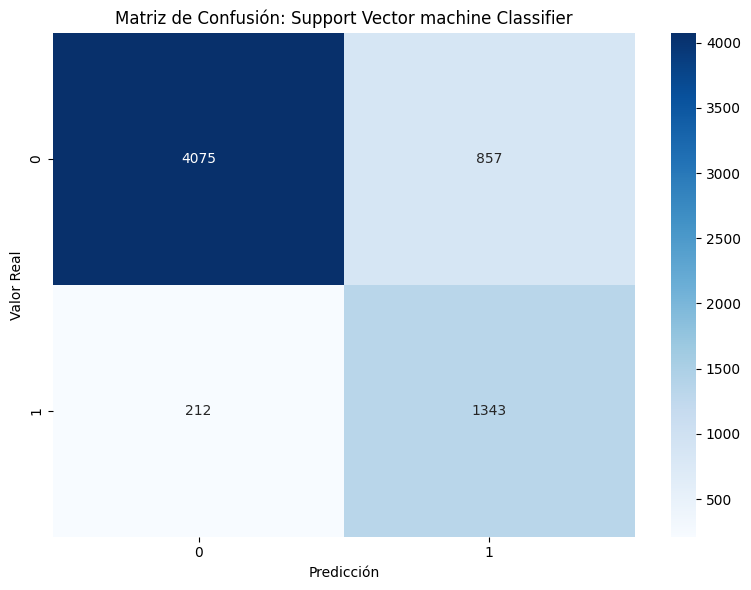

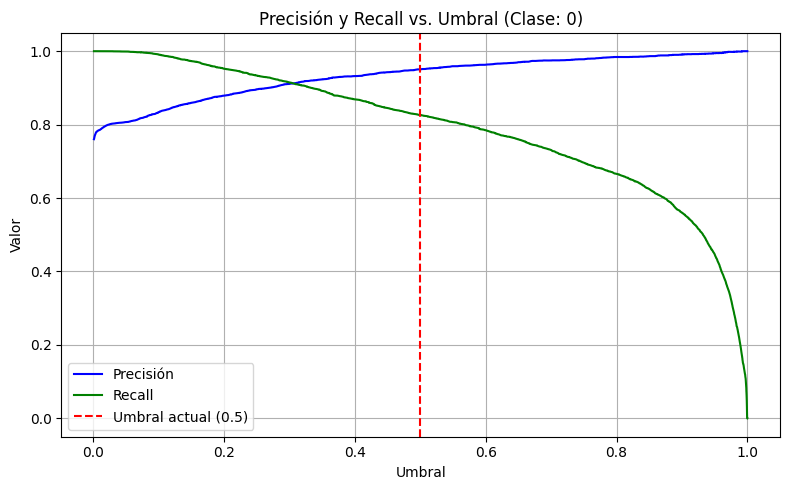

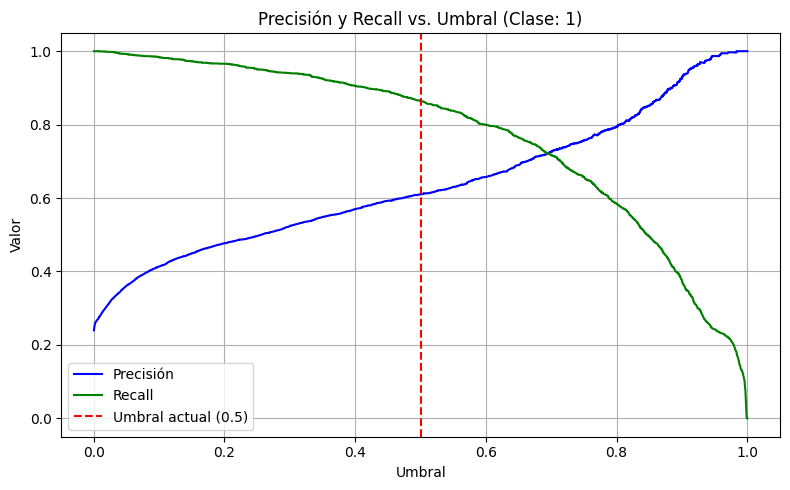

In [51]:
# Cargar el modelo desde el archivo
best_xgb_model = joblib.load("best_xgboost_income_classifier.pkl")

# Predecir valores usando el model
y_pred_best_xgb = best_xgb_model.predict(X_test)

# Calcular probabilidades del modelo por clase
y_proba_best_xgb = best_xgb_model.predict_proba(X_test)

# Evaluar modelo
model_eval("Support Vector machine Classifier", y_test_bin, y_pred_best_xgb, y_proba_best_xgb)

### Conclusiones de la Optimización

Luego de aplicar **RandomizedSearchCV con validación cruzada estratificada** sobre el modelo **XGBoost**, se obtuvo una versión optimizada cuyo desempeño fue comparado contra el **modelo XGBoost original (sin optimizar)**.

Los resultados muestran una clara **mejora en la sensibilidad (recall)** hacia la clase minoritaria `>50K`, que era el objetivo principal de esta optimización:

- El **XGBoost sin optimizar** mostró un rendimiento global sólido, con una **accuracy del 86.85%**, y alta precisión para la clase mayoritaria (`<=50K`). Sin embargo, su **recall sobre la clase `>50K` fue de solo 0.63**, lo que indica que **omitía una cantidad importante de verdaderos positivos**.

- El **XGBoost optimizado**, en contraste, logró un **recall de 0.86** para la clase `>50K`, lo que representa una **mejora significativa en su capacidad para identificar ingresos altos**. Aunque la accuracy global bajó levemente a **83.34%**, el modelo logró un mejor equilibrio entre precisión y sensibilidad sobre ambas clases.

- En resumen:
  - El modelo **sin optimizar** es más conservador, con alta precisión, pero menor sensibilidad hacia la clase positiva.
  - El modelo **optimizado** sacrifica algo de exactitud global en favor de un **recall más alto**, lo que **reduce los falsos negativos** y mejora la equidad en la detección de casos relevantes.

Este ejercicio demuestra que la optimización de hiperparámetros, especialmente con foco en **recall**, puede mejorar sustancialmente el rendimiento del modelo en escenarios con clases desbalanceadas. En contextos donde **es crucial identificar a personas con ingresos >50K**, como análisis económico, **el modelo optimizado representa una opción más adecuada y justa**.

## Insights relevantes para entidad financiera usando el modelo XGBoost optimizado

### Capacidad predictiva sólida
- El modelo XGBoost optimizado alcanza una **precisión general superior al 86%**, con una capacidad destacada para identificar correctamente a individuos con ingresos bajos (`<=50K`).
- A pesar de la **desproporción de clases**, el modelo logró mejorar el **recall** para la clase minoritaria (`>50K`), lo que permite detectar mejor a los individuos con mayor capacidad adquisitiva.

**Valor para el banco o entidad financiera:** Permite segmentar de forma más precisa a los potenciales clientes de alto valor, ayudando en campañas de productos premium o líneas de crédito.

### Identificación equilibrada entre clases
- A través de la optimización enfocada en el **recall**, el modelo reduce el riesgo de pasar por alto a clientes con mayores ingresos.
- El modelo logra un mejor **balance entre precisión y sensibilidad**, especialmente útil para decisiones que involucran **riesgo financiero** (préstamos, tarjetas, etc.).

**Valor para el banco o entidad financiera:** Minimiza falsos negativos, lo cual es crucial para no excluir candidatos que podrían ser solventes financieramente, pero fueron clasificados erróneamente.

### Variables más influyentes
Al analizar la **importancia de características** del modelo XGBoost, suelen destacarse atributos como:

- `education_num` (nivel educativo codificado)
- `hours_per_week` (horas trabajadas por semana)
- `occupation`
- `capital_gain`
- `marital_status`

**Valor para el banco o entidad financiera:** Permite identificar perfiles clave asociados a ingresos altos, lo que puede guiar **segmentaciones de mercado** y **ofertas personalizadas** basadas en educación, actividad económica o estilo de vida.

### Posibilidades de extensión
- El modelo puede extenderse a problemas como:
  - **Scoring crediticio alternativo** (cuando no hay historial bancario)
  - **Segmentación de riesgo** en análisis de cartera
  - **Análisis de propensión** a contratar productos financieros